# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>**attention**</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.

*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by employing LSTMs as an initial embedding mechanism in a transformer's encoder. Learn the strategic process of incrementally training different components of a model — starting with a simple architecture (LSTM), then progressing to more complex structures (transformers). This objective underscores the role of pretraining and its gradual integration to enhance the overall efficacy of neural network models, culminating in superior performance metrics.

* **Enhance Training Efficiency Through Strategic Freezing**: Master the technique of selectively freezing and unfreezing model components at different stages of training. This approach aims to direct the model's learning capacity more effectively, concentrating on specific modules at a time. Understand how this method facilitates a more efficient training process, allowing various parts of the model to adapt incrementally. This objective highlights the value of phased learning, especially beneficial when integrating model components with varying learning dynamics.

*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24)<br>

[Kaggle Dataset Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24/data)<br>

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

Wed May  1 14:28:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   50C    P8              13W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


##  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [ ]:
%%writefile config.yaml

run_name        : "baseline"

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 16 # 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 1                     # [1, 3]
enc_num_heads   : 1                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 3                     # [1, 3]
dec_num_heads   : 3                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "CosineAnnealing"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 5

###### Training Parameters -----------------------------------------------------
epochs          : 50

###### Name --------------------------------------------------------------------
Name: "Alec"                                # write your name here for study group

Writing config.yaml


In [ ]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [ ]:
config

{'run_name': 'baseline',
 'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 16,
 'enc_dropout': 0.2,
 'enc_num_layers': 1,
 'enc_num_heads': 1,
 'dec_dropout': 0.2,
 'dec_num_layers': 3,
 'dec_num_heads': 3,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 5,
 'epochs': 50,
 'Name': 'Alec'}

# Google Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"alectrela","key":"42d0f6df23d52bb3b9e5a7b2cb5e1962"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=cca5a7bce0f53e50325bf393c37eb9790812d0611ef0e9d08fdf2761b59f0560
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [ ]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-hw4p2-slack

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-hw4p2-slack.zip -d ./data

100% 5.45G/5.45G [05:10<00:00, 19.3MB/s]
100% 5.45G/5.45G [05:10<00:00, 18.8MB/s]


# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar.

Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset? (do you require memory efficient loading techniques??)
- How do we load MFCCs? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB -- is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [ ]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [ ]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in self.transcript_files:
            temp = np.load(file)[1:-1]

            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            # @TODO: Uncomment the code below after answering the above questions.
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))

        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?


        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [ ]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [ ]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        = "/content/data/11-785s24-hw4p2/"
PARTITION       = config["train_dataset"]                # Enter your training directory here.
CEPSTRAL        = config["cepstral_norm"]                # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


968

## DataLoader

In [ ]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  16
Train Vatches        :  1784
Val Batches          :  169
Test Batches         :  164


In [ ]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([16, 1672, 27])
x_len shape:		torch.Size([16])

y_shifted_pad shape:	torch.Size([16, 270])
y_golden_pad shape:	torch.Size([16, 270])
y_len shape:		torch.Size([16])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



In [ ]:
def verify_dataset(dataset, partition="train-clean-100"):
    print("Loaded Path: ", partition)

    if partition != "test-clean":
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))

    print()

verify_dataset(train_dataset, partition="train-clean-100")
verify_dataset(val_dataset, partition="dev-clean")
verify_dataset(test_dataset, partition="test-clean")

dataset_max_len = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in val_dataset]),
    np.max([data[0].shape[0] for data in test_dataset]),
)

print("Max Length: ", dataset_max_len)

Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  185.65321139493324

Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547

Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0

Max Length:  3260


# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

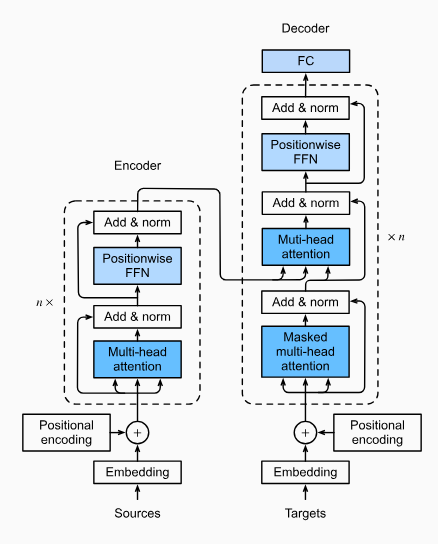

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [ ]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [ ]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [ ]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [ ]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [ ]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [ ]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [ ]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [ ]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 (Preliminary Submission)

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [ ]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [ ]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [ ]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [ ]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = Permute()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## Transformer Decoder

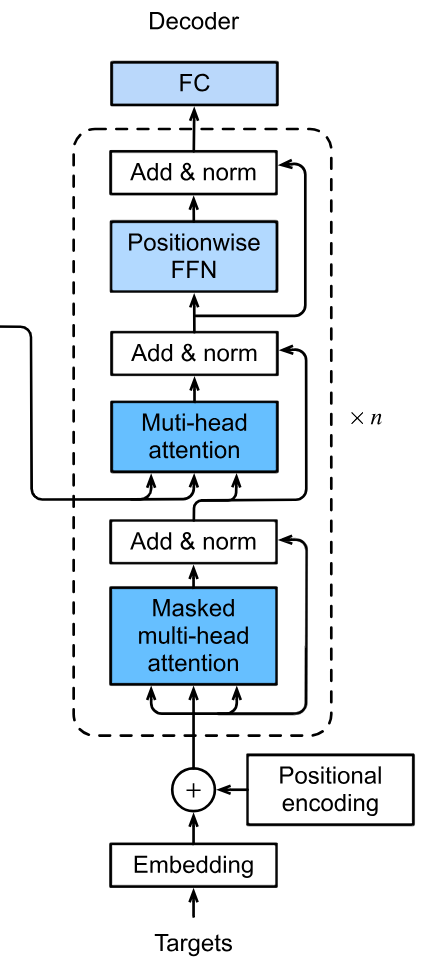

Tips to complete the Decoder below.

* Can you seperate the decoder layers from the whole decoder?
* How many multi-head attention do we have in the figure above.
* How many layer normalizations?
* How do we make the residual connections?

For Forward Method:
* What are the inputs to various multi-head attention modules?
* How do we make the residual connection (do we need dropout)?


In [ ]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)
        self.dropout3   = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        ''' TODO '''
        # q, k, v
        x1, attn1  = self.mha1(padded_targets, padded_targets, padded_targets, mask=slf_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        ''' TODO '''
        x_skip1 = self.dropout1(x1)
        x_skip1 += padded_targets

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        x_skip1 = self.layernorm1(x_skip1)

        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        ''' TODO '''
        x2, attn2 = self.mha2(x_skip1, enc_output, enc_output, mask=dec_enc_attn_mask)

        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        ''' TODO '''
        x_skip2 = self.dropout2(x2)
        x_skip2 += x_skip1

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        x_skip2 = self.layernorm2(x_skip2)

        # Feed Forward Network
        #   (1) pass through the FFN
        ''' TODO '''
        ffn_output = self.ffn(x_skip2)

        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        ''' TODO '''
        ffn_output = self.dropout3(ffn_output)
        ffn_output += x_skip2

        # apply Layer Normalization on this resulting value
        ''' TODO '''
        output = self.layernorm3(ffn_output)

        # return the network output and both attention weights (for mha1 and mha2)
        # @NOTE: returning the self attention weights first
        return output, attn1, attn2


In [ ]:

class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = torch.nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model)
        self.final_linear           = torch.nn.Linear(d_model, target_vocab_size)
        self.dropout                = torch.nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        ''' TODO '''
        pad_mask = None

        # creating an attention mask for the future subsequences (look-ahead mask)
        ''' TODO '''
        slf_attn_mask = create_mask_2(padded_targets)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''
        # import pdb
        # pdb.set_trace()
        _, seq_len = padded_targets.size()
        dec_enc_attn_mask = create_mask_3(enc_output, enc_input_lengths, seq_len)

        # computing embeddings for the target sequence
        ''' TODO '''
        embeddings = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        ''' TODO '''
        encodings = self.positional_encoding(embeddings)
        encodings = self.dropout(encodings)

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        ''' TODO '''
        attention_weights = {}
        output = encodings
        for i in range(self.num_layers):

          output, attn1, attn2 = self.dec_layers[i](
              output,
              enc_output,
              enc_input_lengths,
              dec_enc_attn_mask,
              pad_mask,
              slf_attn_mask)


          attention_weights[f'attn1_{i}'] = attn1
          attention_weights[f'attn2_{i}'] = attn2

        # linear layer (Final Projection) for next character prediction
        ''' TODO '''
        logits = self.final_linear(output)

        # return the network output and the dictionary of attention weights
        return logits, attention_weights


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [ ]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        # self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        # encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [ ]:
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config["input_dim"],
dec_num_layers              = config["dec_num_layers"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config["enc_dropout"],
dec_dropout                 = config["dec_dropout"],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

##########
Model Parameters:
 22.855747
##########


### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

In [ ]:
model.encoder.load_state_dict(torch.load("/content/drive/MyDrive/s24-idl/hw4p2/pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [ ]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [ ]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [ ]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [ ]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [ ]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [ ]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="58cec1d955c8a558ddb5374428c04433fd0455c6", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = config['run_name']
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atrela (atrela-cmu). Use `wandb login --relogin` to force relogin


## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 2.5030	 Train Perplexity 12.7010	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:17<49:47, 17.78s/it, running_distance=500.8125]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE T THE THE THE THE THE THE THE THE THE THE THE T THE THE THE THE THE THE THE THE T T T T T THE T THE THE T 


Val:   1%|          | 2/169 [00:31<42:16, 15.19s/it, running_distance=491.7812]


Ground Truth :  KALIKO HESITATED
Prediction   :  AND WHE WAS WE WAT WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WHE WAT WHE WHE WHE WHE WHE WHE WHE WAT WHE WHE WAS WAT WHE THE THE THE WHE WHE WHE WAS WHE THE THE THE THE WE THE WE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE WE THE WE THE THE THE THE THE THE WE WE THE THE THE THE THE THE THE THE WE WE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE T T THE THE THE THE THE THE THE THE T T T T T T THE THE THE T T


Val:   2%|▏         | 3/169 [00:45<40:32, 14.65s/it, running_distance=494.5417]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE T THE THE THE THE THE THE THE THE THE THE THE T THE THE THE THE THE THE THE THE T T T T T THE T THE THE T 


Val:   2%|▏         | 4/169 [00:58<38:34, 14.03s/it, running_distance=500.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE SE SE SE THE THE THE THE T THE THE THE THE THE THE THE THE THE THE T T T THE THE THE THE THE THE SO SO S S T T S S THE T THE T T T



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE T T THE THE THE THE THE THE THE THE THE THE T T THE THE THE THE THE THE THE THE T T T T T THE T THE THE T 
Levenshtein Distance 502.5000


Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 2.0452	 Train Perplexity 7.8242	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 1.1655	 Train Perplexity 3.2992	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<16:28,  5.88s/it, running_distance=169.5000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR AS SLEPING IN SONCRING THE LOVELY AROSE PRINCESS HAS BECOMOF FITTLE WITH A MERE THE SAID THE POOKED THE SAID TO BE WHO SAID A ME THE SAID THE PIRE WHO SAID THE SAIR THE SURE THE POING DOF THE MAN DOF


Val:   1%|          | 2/169 [00:09<13:01,  4.68s/it, running_distance=142.9375]


Ground Truth :  KALIKO HESITATED
Prediction   :  CHALL A GO A GO AND IN AND IN IN IN IN THE SITE IN THE SAID TO SURE THE SAID THE PIRE THE SAID THE PIRE THE SAID THE SURE THE SAID TO BE AND THE SAID THE PIRE WITH A MORE SURE THE SAID THE SURE THE MIST AND THE MORE SURE THE MAY SHE WITH A MEARE SUIDE AND THE PROOM THE PREAUGHT A HE HE HE


Val:   2%|▏         | 3/169 [00:13<12:08,  4.39s/it, running_distance=129.4583]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  OLLY IS HART LONS WORK ONE AT A STRONG MISURED BREATE


Val:   2%|▏         | 4/169 [00:17<11:14,  4.09s/it, running_distance=123.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  STRINK THE NABLE SOLON IN A TRANCED TO HOLD HIS BODY STIFF AND UNCEPTED TO POINTS THE HAD SUPPED A ME TO SURE THE SAID THE PEW AND HE GIVE TO SURE THE SAID THE SURE THE PEW AS THE ME SURE THE SAID A ME SURE THE MISTER THE PIRE WHE ME SURE THE SAID



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTER THE STACH ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SEE BEING THE SEE BUT WHICH AND THE SOUT SPERE TO SAW THE PIRE THE SOUT AND THE SOUT A ME TO SUT AND THE SOUT SAW THE SOUT A ME SUT A MORE THE SOUT OF IRLAND
Levenshtein Distance 122.6000


Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 0.7160	 Train Perplexity 2.0528	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 0.5500	 Train Perplexity 1.7357	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<17:46,  6.35s/it, running_distance=85.6875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR AS SLEEPING AND SONE OF CONCRING THE LOVELY AROSE PRINCES HAS BECOME OF FITTLE WITH OF A BUT A SURE THE SAID WAS THE MAY SURE TO SURE THE SAID WITH A SURE TO SURE THE MAN SURE TO SURE THE SAID THE WAS THE MARE SURE A COULD HIM TO BEARTHER TO SURE A COUING DUF


Val:   1%|          | 2/169 [00:10<13:51,  4.98s/it, running_distance=59.7500]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALL AGO HENSITATED


Val:   2%|▏         | 3/169 [00:15<13:24,  4.85s/it, running_distance=59.9167]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HART LUNGS WORKED ON AT A STRONG MESURED BREAT


Val:   2%|▏         | 4/169 [00:18<11:20,  4.13s/it, running_distance=54.3438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NABLE SOLON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEART AND HEALT MADE A SURE TO BEARTHER AND WAS THE MAYS WERE TO SURE THE SAID WITH A SURE TO SURE THE SURE THE SURE TO SURE THE COULD THE WERE THE SAID



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTER THE STATE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEE BEING THE INTERIOR OF A CAVE A SOME THE SAWTHERE A SURE TO SURE THE SAID WITH A SURE TO SAID A CONVER TO SUBJUE AND HE WERE THE MAN SUTH OF IRLAND
Levenshtein Distance 51.5875


Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.4589	 Train Perplexity 1.5837	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.3984	 Train Perplexity 1.4906	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<17:36,  6.29s/it, running_distance=58.8750]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SONE OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BO OLD POOR SHAND AND HIS THE WAS A SURE AND BEGARD AND WHICH AND A GENTLED HER WERE TO BEAUT AND A BEEN THE WAS IT A GENTLED HIM TO DEARTH


Val:   1%|          | 2/169 [00:10<13:28,  4.84s/it, running_distance=44.8438]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALLEGO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:18,  3.73s/it, running_distance=35.3542]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART NELUNS WORKED ON AT A STRONG MESURED GREAT


Val:   2%|▏         | 4/169 [00:13<07:21,  2.67s/it, running_distance=31.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINKH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TRUE POINTS THE HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTER THE STATES BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEE BEING THE INTERIOR OF A CAN IN THE SOUTH OF THE WAS A SURE AND BEGARD AND WHICH AND A GENTLED HER AND WAS THE MAY TO BEAR THE WAS IT A GENTLED
Levenshtein Distance 32.0875


Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.3548	 Train Perplexity 1.4267	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.3219	 Train Perplexity 1.3805	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<17:14,  6.16s/it, running_distance=57.0000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SONE OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BO OH OH OF POOR SHAGGE A BEEN THE SAID OF MADE A SEEN OF HIS HAD A BEEN THE NEW EDGED HIM A PERITURE TO BE AND IT WAS THE MARING AND IT WAS IT A COUING DOVE


Val:   1%|          | 2/169 [00:09<13:18,  4.78s/it, running_distance=40.5625]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALLEGO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:18,  3.73s/it, running_distance=32.2292]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART LUNS WORKED ON AT A STRONG MASURE GREAT


Val:   2%|▏         | 4/169 [00:14<08:57,  3.26s/it, running_distance=30.1719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINKTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A SEPT A SURE A SOME IN THE NEW ENTIMED IT WAS IT A BEEN THE WAS IT A BEAUT OF IT A COULD OF THE HAD OF HER AND HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEE BEING THE INTERIOR OF A CAPIN IN THE SOUTH OF IT WAS THE MAY WERE TO EARTH AND WAS THE MARTAIN THE CONVER IT WAS A BEANT A GENTLED IN THE SOUTH OF IRLAND
Levenshtein Distance 30.6750


Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.2949	 Train Perplexity 1.3438	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.2739	 Train Perplexity 1.3156	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<14:35,  5.21s/it, running_distance=43.1875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BO OLD POOR SHAGGE AND MADE BEEN TO EUGHT OF THE HAD WAS THE MIDDER THE MINUTER THE WERE TO BE A BEAUT IN TO EARTH AND EARTHY WERE TO BE


Val:   1%|          | 2/169 [00:06<08:31,  3.06s/it, running_distance=27.8750]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALLOGO HENSITATED


Val:   2%|▏         | 3/169 [00:09<07:51,  2.84s/it, running_distance=23.1875]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:11<07:27,  2.71s/it, running_distance=22.7812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINKTH OF A NEIGHBLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD OF THE HEARTHER IT WAS THE MIDER TO GET MAY WERE TO BE ANY THE WAS NOT AND THE CARRENT IN THE REMER TO BE IN HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF HIM A BEEN TO GET MERE THE WAS THE MIDDER THE MINUTE OF THE HEARTH AND WAS THE MIRE TO BE ANY THE SOUTH OF IRLAND
Levenshtein Distance 24.0750


Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.2557	 Train Perplexity 1.2919	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.2404	 Train Perplexity 1.2722	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<15:57,  5.70s/it, running_distance=51.6875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SONE OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BO OLD POOR SHAGGE A DEPTAINT A BEEN TO A MILLED A BEEN THE WAS A BEEN TO A BEAUT A MILLED A BE A DEAD TO BE A MIDDER TO GUING DOVE


Val:   1%|          | 2/169 [00:07<09:06,  3.27s/it, running_distance=31.7188]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:09<08:00,  2.89s/it, running_distance=25.5625]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY HIS HEART LUNS WORKED ON AT A STRONG MASURE GREAT


Val:   2%|▏         | 4/169 [00:10<05:46,  2.10s/it, running_distance=23.4219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINKTH OF A NEIGHBLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF THE HEARTHER AND WAS A MAYONED A BEEN TO A BE A MILLED A BEEN TO ELEPT HER TO BE WITH A BEEN IN THE SOUTH OF IRLAND
Levenshtein Distance 24.6375


Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.2270	 Train Perplexity 1.2552	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.2146	 Train Perplexity 1.2399	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<15:20,  5.48s/it, running_distance=50.0625]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW OF POOR SHAGGING A DEPTING TO HAVE THE WOULD MADE A DEAT YOU ARE THE MERE AND WHO EUGHT A BEAUTY OF HIS EUR COON DOVE


Val:   1%|          | 2/169 [00:07<09:38,  3.47s/it, running_distance=32.7188]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:09<08:12,  2.97s/it, running_distance=26.1458]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY HIS HEART LUNS WORKED ON AT A STRONG MASURE GREAT


Val:   2%|▏         | 4/169 [00:12<07:35,  2.76s/it, running_distance=24.6406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALT MADE A DEPTINED HIM A BEAUTY OF HIS EUR COULD HIM A DEPTING THE HAD A BEEN TO HAVE THE MERCHANTER AND HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF HIS EUGHTERN THE WOME AND HIS EARTHER AND WHEN THE HEARTHER AND EUGHT OF THE HEARTH AND WHICH IT A PERILAND
Levenshtein Distance 23.7750


Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.2040	 Train Perplexity 1.2266	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.1947	 Train Perplexity 1.2153	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<16:55,  6.04s/it, running_distance=41.2500]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHAGGIS SAIR A COULD HAVE TO DEAR THE WOME TO BE THE PIERCE AND A PIERCE AND A PIERCHED A BUT A DID HEART AND EMPTING DOVE


Val:   1%|          | 2/169 [00:08<11:02,  3.97s/it, running_distance=28.5938]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:07,  3.30s/it, running_distance=23.7500]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY IS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:55,  2.88s/it, running_distance=22.6094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT A NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD A DEAR TO MAKE A BEAUT A NEW PART A PIERCE AND A PIERCE AND A PIERCE AND A PIERCHANT AND HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF HAD A BEEN TO PUT IT A PIERCE AND A PERITY OF IT WAS THE MAY BEAUT PIERCE AND A BEEN TO PUTY OF IRLAND
Levenshtein Distance 21.6250


Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.1861	 Train Perplexity 1.2049	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.1784	 Train Perplexity 1.1957	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<16:14,  5.80s/it, running_distance=38.1875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHAGGIS AND HER TO BE THE COULD HAVE THE KNEW OF THE HORRIEUS AND IT A BEEN THE COULD HAVE THE WOME OF THE HEART OF THE HEART OF


Val:   1%|          | 2/169 [00:08<11:39,  4.19s/it, running_distance=27.9062]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:34,  3.46s/it, running_distance=22.9583]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY HIS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:13<08:25,  3.06s/it, running_distance=22.0000]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALT MADE BE TO MAY WHEN A BEEN A NEW OF THE HOULD HAVE THE BEEN A NEW OF THE HORRIED IT A BEEN A NIELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A BEEN A NEW OF THE HEARTH AND EMPT OF THE HORRIEUS AND HER TO BE THE COULD HAVE TO BE THE COUNT OF IRELAND
Levenshtein Distance 23.2000


Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.1709	 Train Perplexity 1.1867	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.1646	 Train Perplexity 1.1792	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<16:53,  6.03s/it, running_distance=41.5000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHAGGES HIM A DEADY OF MERE AND EUR THE COULD HER THE COULD OF THE KNEW OF THE HEART OF THE PERION IT A BEEN PIECHED AND READ OF


Val:   1%|          | 2/169 [00:08<10:59,  3.95s/it, running_distance=28.7188]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:10<08:57,  3.24s/it, running_distance=23.6042]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:12<06:38,  2.42s/it, running_distance=20.8750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINKTH OF A NABLE SOMEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRROLAND
Levenshtein Distance 18.9625


Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.1590	 Train Perplexity 1.1726	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.1534	 Train Perplexity 1.1660	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:08<23:54,  8.54s/it, running_distance=45.9375]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHAGGED AND EUGHT OF THE WOULD OF THE WAS AND EART OF THE WORT OF IT WAS A BARRIED AND A BARRIADE A SURE A COOLING DOVE


Val:   1%|          | 2/169 [00:10<13:28,  4.84s/it, running_distance=29.9375]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:13<10:29,  3.79s/it, running_distance=24.0208]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:16<09:53,  3.60s/it, running_distance=23.4219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALT OF THE HEART OF IT WAS THE BEEN A LITTLE PIERCHED AND IT WAS THE PART OF A LIEUDENT REPTING THE HEALTH OF HAD A DREW POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS TO BE A LITTLE HAVE THE MANY OF IT WAS THE PERITAGE IT A BEAUT OF THE PART OF A LAND
Levenshtein Distance 22.1250


Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.1480	 Train Perplexity 1.1598	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.1437	 Train Perplexity 1.1548	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:05<15:55,  5.69s/it, running_distance=40.3125]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SON OF CONQUERING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHAGGED A BEAUT POOD THE WOULD OF THE HEARTHER WERE A BUT IT A PIERRITY WHEN A BEAUT OF A HONOUR AND IT A BEAUT OF THE HEARTHERNEYER A COON DOVE


Val:   1%|          | 2/169 [00:08<11:30,  4.13s/it, running_distance=29.0000]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALORGO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:21,  3.39s/it, running_distance=23.5000]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:13<08:28,  3.08s/it, running_distance=22.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALS AND A BEAUT OF THE WOMENT A BUT A BUT A PROMISED AND A WHICH A BEAUT OF THE HEARTHER WITH A BUTTER AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A PIEND A NEW AND A BEEN THE COULD IT A PRESSED AND A PITERRIBLE THE PARTHER WITH A BITTER AND THE SOUTH OF IRELAND
Levenshtein Distance 21.1750


Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.1397	 Train Perplexity 1.1502	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.1356	 Train Perplexity 1.1454	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:44,  6.34s/it, running_distance=40.1250]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING AND SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGIS AND A PIERRA DEADER AND IT A PITIZED HER AND IT A PITER AND IT A PITIERCH AND A SEAR OF A SEAR A COON DOVE


Val:   1%|          | 2/169 [00:09<13:02,  4.68s/it, running_distance=29.0625]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOGO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:12,  3.69s/it, running_distance=23.7917]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY HIS HEART LUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:14,  2.63s/it, running_distance=20.8125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A PIERCE AND IT A PITIZED HER AND IT A PITER AND IT A PIERRIED AND A CARELINED
Levenshtein Distance 19.4500


Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.1317	 Train Perplexity 1.1410	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.1286	 Train Perplexity 1.1374	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:05<15:49,  5.65s/it, running_distance=40.9375]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGED AND IT A NEW OF THE ENTLEMAN IN A NEW OF BEHEARD A NEW OF THE EARTH AND OF THE WOMEN A BUT IT A PEEN OF IT A NEW OF


Val:   1%|          | 2/169 [00:08<10:21,  3.72s/it, running_distance=27.7500]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:10<08:44,  3.16s/it, running_distance=22.5625]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART LUNS WORKED ON AT A STRONG MISER GREAT


Val:   2%|▏         | 4/169 [00:13<08:29,  3.09s/it, running_distance=21.6094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALTER THE EMILITY IN THE REFERED IT A BUT IT A PIENDIA DREADED UP A PIERRITING THE COULD IT ON THE OUTLE IS BODY STIFF AND UNHEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A NEW OF THE EMPTINED OF THE WOMENT A PIERCE OF THE WAS AND EMPT OF THE PERIOD OF BEEN IN THE SOUTH OF IRELAND
Levenshtein Distance 20.5375


Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.1252	 Train Perplexity 1.1336	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.1224	 Train Perplexity 1.1304	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:08<23:29,  8.39s/it, running_distance=45.3125]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGED AND A PIERRANT IT A PEEN OF IT A PETTING OF IT A PERINE OF IT A PEAR OF A PIERRANT A PIERCE AND IT A NEW OF BEHEARD AND IT A NEW OF


Val:   1%|          | 2/169 [00:11<14:13,  5.11s/it, running_distance=30.3125]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALORGO HENSITATED


Val:   2%|▏         | 3/169 [00:13<10:49,  3.91s/it, running_distance=24.2500]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:14<07:45,  2.82s/it, running_distance=20.9688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A PIERCE AND IT A PEEN OF IT A PIERRANT AND IT A PIERCE AND IT A PERINE OF IT A PIERLAND
Levenshtein Distance 19.7625


Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.1197	 Train Perplexity 1.1273	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.1170	 Train Perplexity 1.1243	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<19:27,  6.95s/it, running_distance=41.8750]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGET AND THE COULD IT A PIENDER AND THE COULD IT A PIERCE AND IT A PIEND OF THE PITERED AND BEEN A BEAUT OF THE WELL IT A PIEND OF


Val:   1%|          | 2/169 [00:09<12:05,  4.34s/it, running_distance=28.8125]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:41,  3.51s/it, running_distance=23.2500]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNS WORKED ON AT A STRONG MISEUR GREAT


Val:   2%|▏         | 4/169 [00:15<09:08,  3.33s/it, running_distance=22.3281]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS IT A PIERCE AND IT A PIERCE AND THE COMPANED IT A PIEND A WHICH A BEAUT OF THE PERIOD HAVE BEEN TO BE THE WOOD OF THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A PIENDER AND THE CAN'T HER AND THE PITERED AND THE COULD IT OF THE PERIOD OF HER LAND
Levenshtein Distance 21.1625


Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.1148	 Train Perplexity 1.1218	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.1129	 Train Perplexity 1.1197	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:35,  6.29s/it, running_distance=41.0000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICK AND IT A NIGHT AND IT A BIT A BITTER AND IT A NIGHT OF THE HEARTH AND A PIERCE AND IT A NEW OF BEHEARTHER A COON DOVE


Val:   1%|          | 2/169 [00:09<12:16,  4.41s/it, running_distance=29.0625]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALORGO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:50,  3.55s/it, running_distance=23.5208]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:10,  2.61s/it, running_distance=20.4531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A MIGHT AND THE COULD IT A PIERCE AND IT A PIEND A VICAN AND A NEW OF A CAME IN A SOUTH OF IRELAND
Levenshtein Distance 19.6375


Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.1108	 Train Perplexity 1.1174	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.1090	 Train Perplexity 1.1153	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:05<14:46,  5.27s/it, running_distance=42.6250]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A BEAUT OF THE HEARTH AND EURGHAMMA DEAR OF IT A PIERCE AND EUGHT OF THE MIRATE IT A BEAUT OF THE REVERED AND IT A NIGHTER A COOLING DOVE


Val:   1%|          | 2/169 [00:07<10:02,  3.61s/it, running_distance=28.5938]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALORGO HENSITATED


Val:   2%|▏         | 3/169 [00:10<08:35,  3.11s/it, running_distance=22.9167]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNGS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:11<06:26,  2.34s/it, running_distance=19.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT A PIENDIA DID REPTING THE COULD IT A PIERCE AND IT A PITE OF THE HEARTH AND EUGHTY OF IT AND THE SOUTH OF IRELAND
Levenshtein Distance 19.3875


Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.1077	 Train Perplexity 1.1138	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.1063	 Train Perplexity 1.1123	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:45,  6.34s/it, running_distance=45.3750]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGED AND WHICH A BUTTER AND IT A PIERCE AND IT A PIERCE AND IT A PIERCE AND IT AND IT A BUT IT A NEW OF A BUTTER AND WHEN A BEAUTY OF IT A READ OF IT A BOW ALL POOR SHEGGYS SAIR A COONGED OF


Val:   1%|          | 2/169 [00:09<12:56,  4.65s/it, running_distance=31.4375]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:14,  3.70s/it, running_distance=24.9167]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:15<09:17,  3.38s/it, running_distance=23.2031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALTH OF IT WAS TO BE THE PETING OF THE WOMENT AND IT A BEAUT OF THE HOULD HAVE THE PERIOD IT AND HEALTH OF THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS TO BE THE PETRAINT A BUT IT AND IT AND IT A PIERCE AND IT AND THE PRETTER IT AND A NEW OF THE REALAND
Levenshtein Distance 21.9000


Saved epoch model
Saved best training model

Epoch 40/50



Epoch 40/50: 
Train Loss 0.1050	 Train Perplexity 1.1109	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 41/50



Epoch 41/50: 
Train Loss 0.1039	 Train Perplexity 1.1097	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:04,  6.10s/it, running_distance=41.0625]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A MEANT OF THE PETTING OF THE WOMENT AND IT A PIERCE AND IT A PIEND OF A PIERCHELINE OF IT A PIEND OF IT A BEEN OF


Val:   1%|          | 2/169 [00:08<11:14,  4.04s/it, running_distance=28.2500]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:17,  3.36s/it, running_distance=22.8750]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:14<08:41,  3.16s/it, running_distance=21.9688]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEALS OF CALLETTE AND IT A PIERCE AND IT A BEAUT OF THE WOMPHINESS AND IT A BEAUT OF GETTER IT A BEAUT OF THE REMED IT A DIELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A MADE A DEAR OF GOOD AND WEART A PIENDIA DISH OF THE HEARTH AND A PIEND OF IT A PIERCE AND EUGHTERNAYER OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 21.5375


Saved epoch model
Saved best training model

Epoch 42/50



Epoch 42/50: 
Train Loss 0.1034	 Train Perplexity 1.1091	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 43/50



Epoch 43/50: 
Train Loss 0.1025	 Train Perplexity 1.1081	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:05,  6.10s/it, running_distance=43.5000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH AND EUGHT OF THE WEDDEN A BUT IT A PIENDIA DID WITH A BEEN A BEAUT OF A PIERCE AND IT A BEAUT OF THE WOMEN OF IT A BUTTER A COON DOVE


Val:   1%|          | 2/169 [00:09<12:44,  4.58s/it, running_distance=30.7812]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:07,  3.66s/it, running_distance=24.4792]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:22,  2.68s/it, running_distance=21.1406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A MADE A DEAR OF GOOD AND WEART AND A PIERCE AND A VICAN AND IT AND BEAUT IT A BEAUT OF THE REMED
Levenshtein Distance 20.1875


Saved epoch model
Saved best training model

Epoch 44/50



Epoch 44/50: 
Train Loss 0.1015	 Train Perplexity 1.1069	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 45/50



Epoch 45/50: 
Train Loss 0.1011	 Train Perplexity 1.1065	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:06<17:23,  6.21s/it, running_distance=42.6875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A BUTTER AND IT A PITE OF IT A PIERCE AND IT AND IT A PITE OF THE WERE AND IT A BEAUT OF THE HEARTH AND IT A BITTER A COOLING DOVE


Val:   1%|          | 2/169 [00:09<12:48,  4.60s/it, running_distance=29.9062]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:05,  3.65s/it, running_distance=24.0833]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:15<09:26,  3.43s/it, running_distance=22.9062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS OF IT A BEAUT OF THE WOMENT A BUT IT A PIERCE AND IT AND THE READER AND IT A BARREADED A BEAUT OF THE HEARTHERNESS TO HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A BABY DEAR TO GUICK AND HER AND IT A PIERCE AND A VICAN A BARREADED A BABY A DEBTLE PITTE AND THE SOUTH OF IRELAND
Levenshtein Distance 21.7875


Saved epoch model
Saved best training model

Epoch 46/50



Epoch 46/50: 
Train Loss 0.1007	 Train Perplexity 1.1061	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 47/50



Epoch 47/50: 
Train Loss 0.1004	 Train Perplexity 1.1058	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:05<16:37,  5.93s/it, running_distance=43.2500]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A BUTTER AND IT A PITE OF IT A PIERCE AND A PIERCE AND IT A PIEND OF A BARRAHAMMA DE GETTERED AND EUROPED IT A BITTER A COOLING DOVE


Val:   1%|          | 2/169 [00:08<11:08,  4.01s/it, running_distance=29.1875]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:16,  3.35s/it, running_distance=23.5833]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:12<06:52,  2.50s/it, running_distance=20.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A BABY DEAR TO GET OF THE WOMENT AND IT AND THE PITERED AND IT A BEAUT OF GENTLEMATE AND ACCORDING THE COUNT OF IRELAND
Levenshtein Distance 19.8500


Saved epoch model
Saved best training model

Epoch 48/50



Epoch 48/50: 
Train Loss 0.1002	 Train Perplexity 1.1056	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 49/50



Epoch 49/50: 
Train Loss 0.1002	 Train Perplexity 1.1055	 Learning Rate 0.0000


Val:   1%|          | 1/169 [00:05<16:33,  5.91s/it, running_distance=43.3125]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A BUTTER AND IT A PITE OF IT A PIERCE AND A PIERCE AND IT A PIEND OF A BARRAHAMMA DE GETTERED AND EURGHAMMED A DREADED A BUTTER AND OF


Val:   1%|          | 2/169 [00:08<11:05,  3.98s/it, running_distance=29.2812]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:12,  3.33s/it, running_distance=23.4792]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:12<06:49,  2.48s/it, running_distance=20.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A BABY DEAR TO GUISS AND WHICH A BEEN A PIERCE AND A PIERRAL IN A BABY'S DEAR MAID AND A NEW OF THE IRLAND
Levenshtein Distance 19.5375


Saved epoch model
Saved best training model

Epoch 50/50



Epoch 50/50: 
Train Loss 0.1000	 Train Perplexity 1.1053	 Learning Rate 0.0000
Saved epoch model
Saved best training model


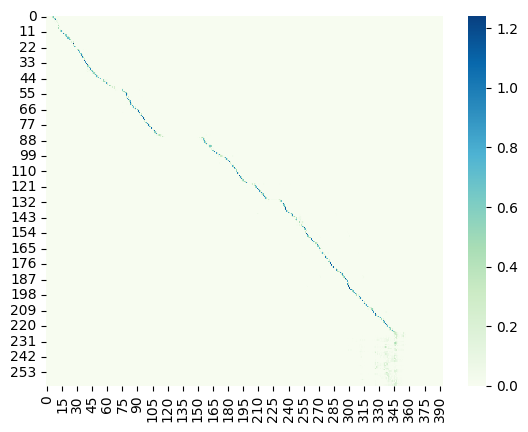

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
valid_actual_distance = validate_full(model, val_loader)

Val:   1%|          | 1/169 [00:06<17:02,  6.09s/it, running_distance=44.0625]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSED PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGED AND A WHICH A BUTTER AND IT A PITE OF IT A PIERCE AND A PIERCE AND IT A PIEND OF A BARRAHAMMA DE GETTERED AND EURGHAMMED A DREADED A BUTTER AND OF


Val:   1%|          | 2/169 [00:09<12:43,  4.57s/it, running_distance=30.9688]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:12<10:01,  3.62s/it, running_distance=24.7500]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:18,  2.66s/it, running_distance=21.2500]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   3%|▎         | 5/169 [00:16<07:43,  2.83s/it, running_distance=20.3500]


Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IT WAS A BABY DEAR TO GUISS AND WHICH A BEEN A PIERCE AND A PIERRAL IN A BABY'S DEAR MAID AND A NEW OF THE IRLAND


Val:   4%|▎         | 6/169 [00:19<07:28,  2.75s/it, running_distance=19.7500]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  IT A MOMENT PEGGY WAS ON THE STAGE AGAIN AN ALEXANDER APPLOTTED VIGOROUSLY WITH THE REST


Val:   4%|▍         | 7/169 [00:22<07:51,  2.91s/it, running_distance=19.5357]


Ground Truth :  I'LL DO ANYTHING YOU WISH ME TO BARTLEY SHE SAID TREMULOUSLY
Prediction   :  ALLS RANNYTHING YOU WISH BE TOO BARLEY SHE SAID TRUMULOUSLY


Val:   5%|▍         | 8/169 [00:23<06:27,  2.41s/it, running_distance=17.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   5%|▌         | 9/169 [00:24<04:50,  1.82s/it, running_distance=15.8889]


Ground Truth :  DON'T CRY DON'T CRY HE WHISPERED
Prediction   :  DON'T CRY DON'T CRY HE WHISPERED


Val:   6%|▌         | 10/169 [00:27<06:22,  2.41s/it, running_distance=15.6500]


Ground Truth :  I'VE BEEN UP IN CANADA WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE
Prediction   :  I'VE BEEN UP AND CANNOTED WITH MY BRIDGE AND I ARRANGED NOT TO YORK UNTIL AFTER YOU HAD GONE


Val:   7%|▋         | 11/169 [00:33<08:58,  3.41s/it, running_distance=15.6818]


Ground Truth :  MANY AMONG THE GENTILE PROSELYTES REFUSED TO BELIEVE THAT A CELESTIAL SPIRIT AN UNDIVIDED PORTION OF THE FIRST ESSENCE HAD BEEN PERSONALLY UNITED WITH A MASS OF IMPURE AND CONTAMINATED FLESH AND IN THEIR ZEAL FOR THE DIVINITY THEY PIOUSLY ABJURED THE HUMANITY OF CHRIST
Prediction   :  MANY AMONG THE GENTILE PRESOLITES REFUSED TO BELIEVE THAT A SOLASTIAL SPIRITS AND UNDIVIDED PORTION OF THE FIRST ESSENCE HAD BEEN PERSONALLY UNITED WITH A MASS OF IMPURE AND CONSIMINATED FLESH AND IN THEIR ZEAL FOR THE DIVINITY THEY PIOSLY OBJURED THE HUMANITY OF CHRIST


Val:   7%|▋         | 12/169 [00:37<09:43,  3.72s/it, running_distance=18.5729]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HIS OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SIS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   8%|▊         | 13/169 [00:43<10:46,  4.14s/it, running_distance=21.0192]


Ground Truth :  THE PAST HE REGRETTED HE WAS DISCONTENTED WITH THE PRESENT AND THE FUTURE HE HAD REASON TO DREAD THE ORIENTAL BISHOPS SUCCESSIVELY DISENGAGED THEIR CAUSE FROM HIS UNPOPULAR NAME AND EACH DAY DECREASED THE NUMBER OF THE SCHISMATICS WHO REVERED NESTORIUS AS THE CONFESSOR OF THE FAITH
Prediction   :  THE PASSED HE REGRETTED HE WAS DISCONTENTED WITH THE PRESENCE AND THE FUTURE HE HAD REASON TO DREAD THE ORIENTAL BISHOPS SUCCESSIVELY DISS ENGAGED THEIR CAUSE FROM HIS UNPOPULAR NAME AND EACH DAYED ACREASED THE NUMBER OF THE SKISMATICS TO REVEARED MYSTORIOUS AS THE CONFESSOR OF THE FAITH


Val:   8%|▊         | 14/169 [00:48<11:23,  4.41s/it, running_distance=22.9330]


Ground Truth :  COSETTE WAS NO LONGER IN RAGS SHE WAS IN MOURNING
Prediction   :  COSETTE WAS NO LONGER IN RIGHTS SHE WAS IN MORNING


Val:   9%|▉         | 15/169 [00:53<12:10,  4.74s/it, running_distance=22.8667]


Ground Truth :  SHE WOULD NOT SPEAK THOUGH WE DANCED A WEEK WITH HER THOUGHTS A THOUSAND LEAGUES OVER THE WATER SINGER SINGER WANDERING SINGER O MY HONEY SWEET SINGER
Prediction   :  SHE WOULD NOT SPEAK THAT WE DANCED TOOKY WITH HER THOUGHTS OF THOUSAND LEAGUES OVERED THE WATER SINGER WANDERING SINGER OH MANY SWERE THE WOULD BE TO BUT IT A PITE OF IT A PIERCE AND A VICAN A PIEND A NEW OF BEHEARTHER AUNT OF THE REGARDENT AND IT SWEET SINGER


Val:   9%|▉         | 16/169 [00:57<11:36,  4.55s/it, running_distance=23.1289]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCHEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  10%|█         | 17/169 [01:02<11:42,  4.62s/it, running_distance=23.2757]


Ground Truth :  THE LONG PEPPER IS LESS AROMATIC THAN THE BLACK BUT ITS OIL IS MORE PUNGENT
Prediction   :  THE LONG PEPPER HIS LESS ARAMATIC THAN THE BLACK BUT ITS VOIL AS MORE PUNGENT


Val:  11%|█         | 18/169 [01:08<12:40,  5.04s/it, running_distance=24.5174]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  THE LEMON WAS FIRST CULTIMATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTRY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN A BEAUT OF MADE A DEAR OF A GOOD OF THE WOMPHOLICAN WERE TO BE A PETTING A BUT IT A BUT IT A PIENDIA DIERCAN IT A BEAUT OF YOUR LEADY IN A REN HOUSES


Val:  11%|█         | 19/169 [01:09<09:41,  3.88s/it, running_distance=23.5559]


Ground Truth :  SUFFICIENT TO SERVE WITH FIVE OR SIX MACKEREL
Prediction   :  OF SUFFICIENT TO SERVE WITH FIVE OR SIX MACREL


Val:  12%|█▏        | 20/169 [01:13<09:53,  3.98s/it, running_distance=23.7437]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DUENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  12%|█▏        | 21/169 [01:18<09:55,  4.02s/it, running_distance=24.1875]


Ground Truth :  NOW WHY IS THAT OTTO
Prediction   :  NOW WISE THAT ARTO


Val:  13%|█▎        | 22/169 [01:22<10:22,  4.24s/it, running_distance=23.8636]


Ground Truth :  WE STOOD PANTING ON THE EDGE OF THE RAVINE LOOKING DOWN AT THE TREES AND BUSHES THAT GREW BELOW US
Prediction   :  WE STOOD PANTING ON THE EDGE OF THE REVENE LOOKING DOWN OF THE TREES AND WOSHES AT RUBELO US


Val:  14%|█▎        | 23/169 [01:27<10:27,  4.30s/it, running_distance=23.8315]


Ground Truth :  I DO NOT BELIEVE IN SUCH REPUBLICS ANY MORE THAN IN THAT OF PLATO OR IF THE THINGS WE READ OF REALLY HAPPENED I DO NOT HESITATE TO AFFIRM THAT THESE SUPPOSED DEMOCRACIES WERE COMPOSED OF VERY DIFFERENT ELEMENTS FROM OURS AND THAT THEY HAD NOTHING IN COMMON WITH THE LATTER EXCEPT THEIR NAME
Prediction   :  I DIDN'T BOTH EVEN SUCH REPUBLICS ANY MORE THAT IN THAT OF PLATEL OR IF THE THINGS WE READ OFF A REALLY HAPPENED I DO NOT HESITATES TO FUM A THESE SUPPOSED DEMOCRACIES WERE COMPOSE OF THE FAIRY DIFFERENT ELEMENTS FROM HOURS AND IT THEY HAD NOTHING IN COMMON WITH THE LETTLE EXCEPT THEIR NAME


Val:  14%|█▍        | 24/169 [01:33<11:37,  4.81s/it, running_distance=24.4427]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALTIE ALSOR ENGLISH IN FRENCH MUSIC THESE NORTHS


Val:  15%|█▍        | 25/169 [01:34<08:44,  3.64s/it, running_distance=23.8975]


Ground Truth :  IT'S THE FIRST TIME HILDA HAS BEEN TO OUR HOUSE AND TOM INTRODUCES HER AROUND
Prediction   :  IT'S A FIRST TIME HILD A HAS BEEN TO OUR HOUSE AND TON THE TRODUCES HER AROUND


Val:  15%|█▌        | 26/169 [01:41<11:21,  4.77s/it, running_distance=24.6346]


Ground Truth :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU
Prediction   :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU


Val:  16%|█▌        | 27/169 [01:46<11:19,  4.78s/it, running_distance=24.5046]


Ground Truth :  I CANNOT THINK WHAT POSSESSES ME THAT I MUST ALWAYS BE WANTING TO COMFORT HIM WHEN HE'S DOWNCAST AND THAT I MUST GO MEDDLING WI HIM TO NIGHT WHEN SURE ENOUGH IT WAS HIS AUNT'S PLACE TO SPEAK TO HIM
Prediction   :  I CANNOT THINK WHAT POSSESSES ME THAT I MUST ALWAYS BE WANTING TO COMFORT HIM WHEN HE'S DOWN CAST AND THAT I MUST GO METALING WITH HIM TO NIGHT WHEN SURE ENOUGH IT WAS HIS AUNT'S PLACE TO SPEAK TO HIM


Val:  17%|█▋        | 28/169 [01:51<11:30,  4.89s/it, running_distance=25.2634]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OF THE HEARTHER IT A PIEND OF IT A BEAUT OF THE WOMPHODES OF THE HEARTHER AND IT A BUT IT A BUT IT A BUTTER AND IT A NEW


Val:  17%|█▋        | 29/169 [01:56<11:40,  5.00s/it, running_distance=25.1810]


Ground Truth :  THEY BEGAN TO LAUGH BOISTEROUSLY WHEN THEY SAW ME CALLING
Prediction   :  THEY BEGAN TO LAUGH BOISTRESSLY WHEN THEY SAW ME CALLING


Val:  18%|█▊        | 30/169 [01:58<09:07,  3.94s/it, running_distance=24.6646]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  HE COULD STAND RIGHT UP AND TOP TO EAL HE GOOD DID HE FIGHT HARD


Val:  18%|█▊        | 31/169 [02:03<09:50,  4.28s/it, running_distance=24.7440]


Ground Truth :  ANTONIA'S FATHER UNCOVERED ONE OF HIS LONG BONY LEGS AND RUBBED IT RHYTHMICALLY
Prediction   :  AND STEE AS FATHER UNCOVERED ONE OF HIS LONG BONY LEGS AND BROBBED IT WRITHNICKLY


Val:  19%|█▉        | 32/169 [02:04<07:59,  3.50s/it, running_distance=24.1270]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  20%|█▉        | 33/169 [02:09<08:45,  3.86s/it, running_distance=24.1875]


Ground Truth :  LIKE THE TWO KINGS OF SPARTA THEY REIGNED JOINTLY DIVIDING BETWEEN THEM THE LABOURS AND CARES OF STATE
Prediction   :  LIKE THE TWO KINGS OF SPARTA THEY RAVING JOINTLY DIFIDING BETWEEN THEM THE LABORS AND CARES OF STEEK


Val:  20%|██        | 34/169 [02:15<09:52,  4.39s/it, running_distance=24.4669]


Ground Truth :  SEVENTEEN SEVENTEEN
Prediction   :  SEVENTEEN SEVENTEEN


Val:  21%|██        | 35/169 [02:21<10:42,  4.80s/it, running_distance=25.2464]


Ground Truth :  MAIZE NEXT TO WHEAT AND RICE MAIZE IS THE GRAIN MOST USED IN THE NOURISHMENT OF MAN
Prediction   :  MAZE NEXT TO WEED IN RICE MAZES THE GRAIN MOST USED IN THE NOURISHMENT OF MAN


Val:  21%|██▏       | 36/169 [02:26<11:13,  5.06s/it, running_distance=25.5556]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SCLEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWERE AND A PITE OF IT A BUTTOGET AND A PIERCE AND A VICAN A BEAUT OF A PIERCE AND A BABY TO BE THE WOOD


Val:  22%|██▏       | 37/169 [02:30<10:25,  4.74s/it, running_distance=25.2500]


Ground Truth :  ILLUSTRATION RUSKS
Prediction   :  ILLUSTRATION RUSKS


Val:  22%|██▏       | 38/169 [02:37<11:31,  5.28s/it, running_distance=26.3388]


Ground Truth :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACE BESIDES IN CONSEQUENCE OF TOO STRICT A WATCHFULNESS TO KEEP IT PURE
Prediction   :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACED BESIDES IN CONSEQUENCE OF TWO STRICK TO WATCHFULNESS TO KNOW HIM A BEAUT OF THE WOMENT A BUT IT A PIERCE AND IT A BEAUT OF THE WOMENT AND IT A NEW OF THE REMET AND IT A NEW OF THE READER AND IT A BUTTER


Val:  23%|██▎       | 39/169 [02:42<11:10,  5.16s/it, running_distance=26.9471]


Ground Truth :  THERE IS A WONDERFUL INSIGHT IN HEAVEN'S BROAD AND SIMPLE SUNSHINE
Prediction   :  THERE IS A WONDERFUL INSIGHT IN HEAVEN'S BROAD AND SIMPLE SUNSHINE


Val:  24%|██▎       | 40/169 [02:43<08:54,  4.14s/it, running_distance=26.5109]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINTED TO GARROW TYPEST BECAUSE LIKE AN OLD LADY'S COUP OF TEA IT IS WATER BEWITCHED


Val:  24%|██▍       | 41/169 [02:49<09:29,  4.45s/it, running_distance=26.6250]


Ground Truth :  THE WALLS OF THE ROOMS WERE DISCORDANTLY PAPERED
Prediction   :  THE WALLS OF THE ROOMS WERE DISCORDENTLY PAPRIED


Val:  25%|██▍       | 42/169 [02:50<07:24,  3.50s/it, running_distance=26.1280]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  HE WAS AN EFFEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE


Val:  25%|██▌       | 43/169 [02:51<05:53,  2.81s/it, running_distance=25.6802]


Ground Truth :  FORTUNATELY THERE WAS NOTHING FROM HIS WIFE EITHER
Prediction   :  PORTUNATELY THERE WAS NOTHING FROM HIS WIFE EITHER


Val:  26%|██▌       | 44/169 [02:53<05:18,  2.54s/it, running_distance=25.2188]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVED TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  27%|██▋       | 45/169 [02:55<05:00,  2.42s/it, running_distance=24.8458]


Ground Truth :  FOR RELIEF HE AROSE AND JOINED IN CONVERSATION WITH A FEW FRIENDS WHO WERE DRINKING
Prediction   :  FULL RELIEF HE AROUSE AND JOINED IN THE CONVERSATION WITH A FEW FRANCE THEY WERE DRINKING


Val:  27%|██▋       | 46/169 [02:59<05:59,  2.93s/it, running_distance=24.8342]


Ground Truth :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRIE BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SAW A MAN WATCHING HIM AND WENT AWAY
Prediction   :  HE DID MANAGED TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRY BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SOUGHT MAN MATCHING HIM AND MET AWKED A GIRL IT A BUTTOGET AND IT A PIERCE AND IT A PIEND A BARREADED A BEAUT OF YOUR AND MET AWAY


Val:  28%|██▊       | 47/169 [03:03<06:25,  3.16s/it, running_distance=24.7301]


Ground Truth :  I MUST NOT CONCLUDE WITHOUT EXPRESSING MY MOST SINCERE THANKS TO MY CRITICS AND TO THE PUBLIC FOR THE LENIENCY AND CONSIDERATION WITH WHICH THEY HAVE TREATED MY ADVENTURES
Prediction   :  I MUST NOT THINK LED WITHOUT EXPRESSING MY MOST INSEARED THANKS TO MY CRITICS AND TO THE PUBLIC FOR THE LANIANCY AND CONSIDERATION WITH WHICH THEY HAD A PEENTURED AND IT A PITERS


Val:  28%|██▊       | 48/169 [03:09<08:17,  4.11s/it, running_distance=25.0365]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THAT SHEEP NONNESS AS AIRLY CLOSET HAND OR TO GET THE MINUS INGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE RONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT HIM OF EIGHT HUNDRED OF THEM AND BEING ALL BREATING USE THEY WERE PRETTY QUIET


Val:  29%|██▉       | 49/169 [03:12<07:33,  3.78s/it, running_distance=24.9872]


Ground Truth :  THEIR EXPRESSION WAS DIVINE AND AS THEY GLANCED AT ME TIMIDLY BUT WITH PARTED LIPS IN GREAT BEWILDERMENT I FORGOT ALL THOUGHTS OF THEIR CONVERSION IN FEELINGS THAT WERE FAR MORE EARTHLY
Prediction   :  THEIR EXPESSION WAS DIVINE AND AS THEY GLANCE IT ME IT LEAVES INGREATED LIPS INGREATED THE WILDERMAND I FORGOT ALL THOUGHTS OF THEIR CONVERSION IN FEELINGS THAT WERE FARM ARTHLY


Val:  30%|██▉       | 50/169 [03:17<08:09,  4.11s/it, running_distance=25.8100]


Ground Truth :  THE DESIGN WAS DIFFERENT BUT THE THING WAS CLEARLY THE SAME
Prediction   :  THAT HIS EYE WAS DIFFEREMED BUT THE THING WAS CLARELY THE SAME


Val:  30%|███       | 51/169 [03:21<08:07,  4.13s/it, running_distance=25.8860]


Ground Truth :  I EVEN BOUGHT SOMETHING FOR MADGE I MEAN MISSUS WILSON
Prediction   :  I EVEN BOUGHT SOMETHING FROM EDGE I MEAN MISSUS WILSON


Val:  31%|███       | 52/169 [03:25<07:57,  4.08s/it, running_distance=25.8305]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  31%|███▏      | 53/169 [03:30<08:11,  4.24s/it, running_distance=25.7960]


Ground Truth :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT WEEK OR THE WEEK AFTER CERTAINLY AT THE EARLIEST POSSIBLE MOMENT AND I SHOULDN'T BE AT ALL SURPRISED TO LEARN THAT ALL MARY ANN'S THINGS HAD BEEN ALREADY BOUGHT AND PERHAPS SOME OF THEM MARKED
Prediction   :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT SWEEK OR THE WEEK AFTER CERTAINLY AT THE EARLY AS POSSIBLE MOMENT AND I SHOULDN'T BE AT ALL SURPRISED TO LEARN THAT ALL MARY ENDS THINGS HAVE BEEN ALREADY BOUGHT AND PRAPS SOME OF THEM MARKED


Val:  32%|███▏      | 54/169 [03:31<06:33,  3.42s/it, running_distance=25.3773]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  IT TURNED OUT THAT SHE HAVE A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR


Val:  33%|███▎      | 55/169 [03:33<05:20,  2.81s/it, running_distance=25.0341]


Ground Truth :  THAT WAS WHAT MISSUS MACPHERSON SAID TO ME ONLY THE OTHER DAY
Prediction   :  THAT WAS WHAT MISSUS MICK FIERCEN SAID TO ME ONLY THE OTHER DAY


Val:  33%|███▎      | 56/169 [03:34<04:35,  2.44s/it, running_distance=24.7254]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MEN WAS CLAD IN A BROWN CAMEL HERE ROBE AND SANDALS AND A GREEN TURBIN WAS ON HIS HEAD


Val:  34%|███▎      | 57/169 [03:36<03:58,  2.13s/it, running_distance=24.4211]


Ground Truth :  YOU HAVE NEVER DISOBEYED ME OBEY MY LAST COMMAND
Prediction   :  I'VE NEVER DISOBLAYED ME OH BAY MY LAST COMMAN


Val:  34%|███▍      | 58/169 [03:41<05:38,  3.05s/it, running_distance=24.6175]


Ground Truth :  YES CHARCOAL
Prediction   :  YES JARKOLL


Val:  35%|███▍      | 59/169 [03:45<05:55,  3.23s/it, running_distance=24.6801]


Ground Truth :  BUD THREW UP HIS ARMS TO PROTECT HIMSELF BUT TOO LATE
Prediction   :  BUT THROUGH UP HIS ARMS TO PRODECT HIMSELF BUT TWO LATE


Val:  36%|███▌      | 60/169 [03:49<06:15,  3.45s/it, running_distance=24.5292]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  36%|███▌      | 61/169 [03:52<06:09,  3.42s/it, running_distance=24.4447]


Ground Truth :  THINK OF LADY GLENARVAN THINK OF MARY GRANT
Prediction   :  THINK OF LIGHTY CALL AN ARBIN THINK OF MARY GRAND


Val:  37%|███▋      | 62/169 [03:55<05:55,  3.32s/it, running_distance=24.4395]


Ground Truth :  ON THAT SIDE DESCENT WAS IMPOSSIBLE AND HAD IT BEEN POSSIBLE THE BOTTOM WAS SHUT IN BY THE ENORMOUS ROCK
Prediction   :  ON THAT SIDE DESCENT WAS IN TOSSIP AND HAD IT BEEN POSSIBLE BOTTOM WAS SHUT IN BY THE ENORMERS WERE ALK


Val:  37%|███▋      | 63/169 [03:59<06:09,  3.48s/it, running_distance=24.5079]


Ground Truth :  THE ENTRANCE IS LIGHT BECAUSE IT OPENS SO WIDE BUT WE CAN SEE THAT THE FLOOR SLOPES DOWNWARD AND THE WAY LOOKS DARK AND NARROW BEFORE US
Prediction   :  THE ANTRANCE'S LIGHT BECAUSE IT OPEN SO WIDE BUT WE CAN SEE THAT THE FLOOR SLOPED DOWN WORD AND THE WAY LOOKS DARKED AND NARROW BEEN A BUTTER AND IT A BIT IT A BUTTOGET AND A PIERCE AND A VICAN A BUTTER AND A BARREASTS


Val:  38%|███▊      | 64/169 [04:04<06:43,  3.84s/it, running_distance=24.9814]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF THE MORALITY ATTACHES ARE ENT OF THIS BOOK OR TO THE LEADING FALOSS OF HERSEVER SCHOOL PROCERVAL KING THE HEARTHER AND IT A BEAUT OF THE PERSEVERAL CENTURIES


Val:  38%|███▊      | 65/169 [04:11<08:44,  5.05s/it, running_distance=25.8115]


Ground Truth :  THAT WONDERFUL METAPHYSIC SUBTLETY WHICH IN PHRASES AND DEFINITIONS TOO OFTEN UNMEANING TO OUR GROSSER INTELLECT SAW THE SYMBOLS OF THE MOST IMPORTANT SPIRITUAL REALITIES AND FELT THAT ON THE DISTINCTION BETWEEN HOMOOUSIOS AND HOMOIOUSIOS MIGHT HANG THE SOLUTION OF THE WHOLE PROBLEM OF HUMANITY WAS SET TO BATTLE IN ALEXANDRIA THE ANCIENT STRONGHOLD OF GREEK PHILOSOPHY WITH THE EFFETE REMAINS OF THE VERY SCIENTIFIC THOUGHT TO WHICH IT OWED ITS EXTRAORDINARY CULTURE
Prediction   :  THAT WONDERFUL METAPHYSIC SUFFLETY WHICH IN FRACES AND DEFINITIONS TO OFTEN UNMEANING TO OUR A GROSS HER INTELLECT SAW AT THE SIMBLES OF THE MOST IMPORTANT SPIRITUAL REALITIES AND HOME OF LOSIUS AND HOMELIZEUS AND HOMELIZACE AND HOME OF LOSIUS AND HOMELIZIUS AND HOME OF THE VERY SCIENTIFIC THOUGHT TO WHICH IT OWED TIXT DERRICULTURE


Val:  39%|███▉      | 66/169 [04:17<08:43,  5.08s/it, running_distance=25.9782]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE AND MOVED MY ECHANIMITY BUT IF I COULD STOOP TO PATE I SHOULD HAVE TO BE THE PUT OF IT A BUTTOGET AND A PIERCE AND A VICAN A BEAUT OF A PIERCE AND IT A NEW OF THE REAT HER


Val:  40%|███▉      | 67/169 [04:21<08:05,  4.76s/it, running_distance=26.0140]


Ground Truth :  THEN THE SHINING OF THE WET LEAVES IS DELIGHTFUL AND THE STEAMY FRAGRANCE AND THE BURST OF BIRD SONG FROM A MULTITUDE OF THRUSHES AND FINCHES AND WARBLERS THAT HAVE NESTS IN THE CHAPARRAL
Prediction   :  THEN THE SHONING OF THE WED LEAVES IS DELIFLE AND THE STEAMY FRIGRANCE AND A BURST OF BIRDS SONG FROM A MULTITUDE OF THRUSHES AND FINCHES AND WARBLERS THAT HAVE NESTS IN THE SHEPHERO OUT OF NESTS IN THE SHEPHERO


Val:  40%|████      | 68/169 [04:25<07:39,  4.55s/it, running_distance=25.9908]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEATHED THE GLORIFITE WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  41%|████      | 69/169 [04:31<08:34,  5.14s/it, running_distance=26.4402]


Ground Truth :  THE BIG MEADOWS LIE NEAR THE FOOT OF LASSEN'S BUTTE A BEAUTIFUL SPACIOUS BASIN SET IN THE HEART OF THE RICHLY FORESTED MOUNTAINS SCARCELY SURPASSED IN THE GRANDEUR OF ITS SURROUNDINGS BY TAHOE
Prediction   :  THE BAKE MENAUS LINE NEAR THE FOOT OF LASTEN'S BEAUT A BEAUTIFUL SPACIOUS PACION SAID IN THE HART OF THE RICHLY FOREST AND MOUNTAINS SCARCELY SURPASSED IN THE GRANDER OF ITS SURROUNDINGS BY DOLL


Val:  41%|████▏     | 70/169 [04:34<07:28,  4.53s/it, running_distance=26.3027]


Ground Truth :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS FURTIVE WATCHER
Prediction   :  WHY INQUIRED OF GEORGE WITH MY EYES AND STILL ON THIS FURTITH WATCHER


Val:  42%|████▏     | 71/169 [04:36<06:15,  3.83s/it, running_distance=26.1215]


Ground Truth :  THE SUGGESTION HE HAD LAUGHED AT WAS NOT SO ENTIRELY FOOLISH AS HE HAD BEEN PLEASED TO CONSIDER IT
Prediction   :  THE SUGGESTION HE HAD ALAUGHED DAD WASN'T SO ENTERLY FOOLISHED AS HE HAD BEEN ABLEASED TO CONSIDERATENTION


Val:  43%|████▎     | 72/169 [04:40<05:52,  3.63s/it, running_distance=25.9644]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEET WATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTTER JASE AND MORE OR LESS ALA FAVORITE


Val:  43%|████▎     | 73/169 [04:41<04:43,  2.96s/it, running_distance=25.7312]


Ground Truth :  NOT TILL THE DOCTOR CAME HER DOCTOR WHO WAS HAPPILY IN HIS OFFICE IN THIS VERY BUILDING
Prediction   :  NOT TILL THE DARGER CAME HER DAUGHT DREW WITH HAPPLY IN HIS OFFICE IN THIS VERY BUILDING


Val:  44%|████▍     | 74/169 [04:42<03:57,  2.50s/it, running_distance=25.5253]


Ground Truth :  MISS CLARKE STARTED AND HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY DID I SHE QUERIED MUSINGLY
Prediction   :  MISS CLARK STARTED BENET AND AT HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY AND ONCE SHE QUARRIED AM USINGLY


Val:  44%|████▍     | 75/169 [04:49<05:36,  3.58s/it, running_distance=25.7575]


Ground Truth :  BESIDES I WAS OF OPINION THAT A MAN'S PROFESSION WHATEVER IT MIGHT BE OUGHT TO SUPPLY HIM WITH ENOUGH MONEY TO SATISFY ALL HIS WANTS AND THE VERY POOR PAY OF AN OFFICER WOULD NEVER HAVE BEEN SUFFICIENT TO COVER MY EXPENSES BECAUSE MY EDUCATION HAD GIVEN ME GREATER WANTS THAN THOSE OF OFFICERS IN GENERAL
Prediction   :  BESIDES OH WAS OF OPINION THAT A MAN'S PROFESSION WHATEVER IT MY BE OUGHT TO SUPPLY HIM WITH ENOUGH MONEY TO SATISFY ALL HIS ONCE AND BE VERY POOR PAY OF AN OPPOSER WOULD NEVER HAVE BEEN SUPPICION TO COVER MY EXPENSES BECAUSE MY EDUCATION HAD GIVEN ME GREATER ONCE THAN THOSE OF OPPOSSERS AND GENERAL


Val:  45%|████▍     | 76/169 [04:54<06:13,  4.02s/it, running_distance=25.9301]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLED TO HIM


Val:  46%|████▌     | 77/169 [04:57<06:01,  3.93s/it, running_distance=25.8937]


Ground Truth :  HE WROTE THE QUESTION AND GAVE IT TO ME I READ IT I COULD NOT UNDERSTAND EITHER THE SUBJECT OR THE MEANING OF THE WORDS BUT IT DID NOT MATTER I HAD TO GIVE AN ANSWER
Prediction   :  HE WROTE THE QUESTION AND GAVE IT TO ME I READ IT I CANNOT UNDERSTAND EITHER THE SUBJECT OR THE MEANING OF THE WORDS BUT IT A DID NOT MATTER IT A PITE A PIERCE AND WE'VE A PIERCE AND A VICAN ANYTHOUGH AND ENSWER


Val:  46%|████▌     | 78/169 [05:03<06:33,  4.32s/it, running_distance=26.2067]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  YET I DID THE WATCH FULL MISS WOODLY OFTEN TIMES HERE A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WITH A BEEN A BUTTER AND IT A PIECE


Val:  47%|████▋     | 79/169 [05:07<06:41,  4.46s/it, running_distance=26.5214]


Ground Truth :  MISS WOODLEY THOUGHT IT HER DUTY TO BE MUTE AND NOW THE GINGLE OF A TEA SPOON WAS LIKE A DEEP TONED BELL ALL WAS SO QUIET
Prediction   :  MISS WOODLY THOUGHT IT HER DUTY TO BE MUTE AND NOW THE CHINGLE OF A TEAST BOON WAS LIKE A DEEP TONE TO BELL ALL WAS SO QUIET A PIERCE AND IT A PIEND OF IT A BUTTOGET AND A PIERCE AND A VICAN A BEAUT OF A PIERCE AND IT A NEW OF THE REGARDENT AND IT A NIGHT OF IT A DEEP TONE TO BELL ALL WAS SO QUIET


Val:  47%|████▋     | 80/169 [05:12<06:46,  4.57s/it, running_distance=26.9250]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTECT WITH SOME OF IT A BEAUT OF THE WOMENT A BUT IT AND IT ARE IT AND A VICAN ANYTHOUGH AND EUGHTERNAMITE AUNTIC AND EUGHTERNAYER IT AND IT A NIGHTER AND EDICT WITH SOMESEAL


Val:  48%|████▊     | 81/169 [05:17<06:39,  4.54s/it, running_distance=26.9938]


Ground Truth :  BOZZLE HAD ALWAYS WAITED UPON HIM WITH A DECENT COAT AND A WELL BRUSHED HAT AND CLEAN SHOES
Prediction   :  BOSSEL HAD ALWAYS WAITED UPON HIM WITH THE DECENT COAT AND A WELL BRUSH HATS IN CLEAN SHOES


Val:  49%|████▊     | 82/169 [05:22<06:58,  4.81s/it, running_distance=27.2325]


Ground Truth :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MONTESINOS AND SAW DULCINEA TRANSFORMED INTO A COUNTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASS AGAIN THAT THE WORDS OF THE SAGE MERLIN WERE SOUNDING IN HIS EARS SETTING FORTH THE CONDITIONS TO BE OBSERVED AND THE EXERTIONS TO BE MADE FOR THE DISENCHANTMENT OF DULCINEA
Prediction   :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MALTICINOS AND SAW DOSONANA TRANSFORMED INTO A CUTRY WANCH SKIPPING AND MOUNTING UPON HER SHE ASKED AGAIN THAT THE WORDS OF THE SATURE MERLAND WERE SOUNDING IN HIS EARS SETTING FORTH A DISANT CHANTMENT OF DELSINATE


Val:  49%|████▉     | 83/169 [05:26<06:22,  4.45s/it, running_distance=27.1980]


Ground Truth :  IN A WORD HE PLEDGED HIMSELF TO BE MINE AND I PROMISED TO BE HIS WITHOUT CARRYING MATTERS ANY FURTHER
Prediction   :  IN A WORD HE PLEDGED HIMSELF TO BE MIND AND I PROMISED TO BE HIS WITHOUT CARRYING MATTERS THAN HE FURTHER


Val:  50%|████▉     | 84/169 [05:32<07:07,  5.03s/it, running_distance=27.5551]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG IN AFTER DISTURB THE QUIETEST HEARTS


Val:  50%|█████     | 85/169 [05:37<06:57,  4.97s/it, running_distance=27.7199]


Ground Truth :  I ORDER YOU SIR NORTH CRIED INDIGNANT
Prediction   :  I ORDER YOU SIR NORTH CRIED IN DIGNANT


Val:  51%|█████     | 86/169 [05:37<05:04,  3.67s/it, running_distance=27.4622]


Ground Truth :  KIRKLAND JUMPED FOR THE JETTY MISSED HIS FOOTING AND FELL INTO THE ARMS OF THE CHAPLAIN
Prediction   :  COURKLIN JUMPED FOR THE JEDDY MISSED HIS FOOTING AND FELL UNDER THE ARMS OF THE CHAPLAIN


Val:  51%|█████▏    | 87/169 [05:38<03:40,  2.68s/it, running_distance=27.1717]


Ground Truth :  HE IS JUST MARRIED YOU KNOW IS HE SAID BURGESS
Prediction   :  HE IS JUST BARRY DO KNOW IS HE SAID BURGESS


Val:  52%|█████▏    | 88/169 [05:41<03:55,  2.90s/it, running_distance=27.0007]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 89/169 [05:43<03:29,  2.62s/it, running_distance=26.7619]


Ground Truth :  GOOD NIGHT SIR I HOPE YOU WILL BE COMFORTABLE
Prediction   :  GOOD NIGHT SIR I HOPE YOU WILL BE COMFORTABLE


Val:  53%|█████▎    | 90/169 [05:44<02:46,  2.11s/it, running_distance=26.5257]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  I'LL REPORTHUS TO THE GAVERNMENT


Val:  54%|█████▍    | 91/169 [05:47<03:09,  2.43s/it, running_distance=26.4959]


Ground Truth :  I FEEL LIKE A BOY OUT OF SCHOOL OR RATHER A MAN OUT OF PRISON AND MUST ENJOY MY LIBERTY IN SOME WAY
Prediction   :  I FEEL I CA BOY OUT OF SCHOOL OR RATHER A MAN OUT OF PRISON AND MUST ENJOY MY LIBERTY IN SOME WAY


Val:  54%|█████▍    | 92/169 [05:51<03:34,  2.79s/it, running_distance=26.5788]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SO KIND SHE NEIGHBORLY MAN AND TO SPORE WILL TAKE MY PLACE ABEL THE HOUSE AND PROTECTY FACELY


Val:  55%|█████▌    | 93/169 [05:57<04:41,  3.70s/it, running_distance=26.9026]


Ground Truth :  HIS WIFE FED HIM WITH THE FAT OF THE LAND REGARDLESS OF CONSEQUENCES HIS CHILDREN REVOLVED ABOUT HIM WITH TIRELESS CURIOSITY AND WONDER HIS NEIGHBORS FLOCKED IN TO APPLAUD ADVISE AND ADMIRE EVERY ONE TREATED HIM WITH A RESPECT MOST GRATEFUL TO HIS FEELINGS HE WAS AN OBJECT OF INTEREST AND WITH EVERY HOUR HIS IMPORTANCE INCREASED SO THAT BY NIGHT HE FELT LIKE A COMMANDER IN CHIEF AND BORE HIMSELF ACCORDINGLY
Prediction   :  HIS WIFE SAID HIM WITH THE THOUGHT OF THE LAND REGADLESS OF CONSEQUENCES HIS CHILDREN WERE REVOLVED ABOUT HIM WITH TIRELESS CURIOSITY AND WONDER HIS NEIGHBOURS FLOCKED INTEREST AND WITH EVERY OUTER HIS IMPORTANCE INCREASE SO THAT BY NIGHT HE FOOT LIKE A COMMANDER IN CHIEF AND BOUGHT HIMSELF ACCORDINGLY


Val:  56%|█████▌    | 94/169 [06:02<05:00,  4.00s/it, running_distance=26.9162]


Ground Truth :  DAVID AND CHRISTIE WENT SMILING AWAY TOGETHER AND IF THEY SHED ANY TEARS OVER THE BRIEF HAPPINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS
Prediction   :  DIF IT INCRISTY WENT SMILING AWAY TOGETHER AND IF THEY SHAD ANY TEARY SUFFERED THE BRIEF HAPPINESS NO ONE SAW THEM WITH THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS


Val:  56%|█████▌    | 95/169 [06:09<06:15,  5.07s/it, running_distance=27.1309]


Ground Truth :  THE MOST VARIED EXPERIENCE TEACHES IT WHAT ARE THE QUALITIES TO WHICH IT PRINCIPALLY OWES THE FACT THAT IT STILL EXISTS IN SPITE OF ALL GODS AND MEN AND HAS HITHERTO BEEN VICTORIOUS THESE QUALITIES IT CALLS VIRTUES AND THESE VIRTUES ALONE IT DEVELOPS TO MATURITY
Prediction   :  THE MOST VARIED EXPERIONS TEACHES AT WHAT BY THE QUALITIES TO WHICH IT PRINCIPLY OSE THE FACT THAT IT STILL EXISTS IN SPITE OF ALL GODS AND MEN AND HESITHER TWO BEN VICTORIOUS THESE QUALITIES IT CALLS VIRTUOUS AND THE USEVERTUOUS ALONE AT DEVELOPS TO MATURITY


Val:  57%|█████▋    | 96/169 [06:16<06:53,  5.66s/it, running_distance=27.4036]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PARMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FIRACTION HAVE BEEN USED AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TO HEAVY


Val:  57%|█████▋    | 97/169 [06:25<08:01,  6.68s/it, running_distance=27.7912]


Ground Truth :  THE HOUSE WHICH SEEMED TO CONSIST OF TWO OR THREE HIGH NARROW AND STEEP ROOFED BUILDINGS PROJECTING FROM EACH OTHER AT RIGHT ANGLES FORMED ONE SIDE OF THE INCLOSURE
Prediction   :  THE HOUSE WHICH SEEMED TO CONSIST OF TWO OR THREE HIGH NEAROW AND STEEP ROOFED BUILDINGS PROJECTING FROM ENCHATHER AT RIDE AND A BEAUT OF MADE A DEAR OF A BARRAPID A PIERCE AND IT A BEAUT OF THE WOMENT AND IT A BUT IT A BEAUT OF THE ENCLOSURE


Val:  58%|█████▊    | 98/169 [06:29<06:51,  5.80s/it, running_distance=27.8769]


Ground Truth :  THEY HELD CONVENTICLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE AND CRUELTY BY THE SCOTTISH GOVERNMENT MORE THAN ONCE TOOK ARMS DURING THOSE REIGNS
Prediction   :  THEY HOWED CONVENTABLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE IN CRUELTY BY THE SCOTTISH GOVERNMENT WERE THAN ONCE TO CARLETTE A PIERCE AND IT A BEAUT OF THE WORKEYED UP A PIERCE AND A PIENDS


Val:  59%|█████▊    | 99/169 [06:32<05:48,  4.98s/it, running_distance=27.8056]


Ground Truth :  ARE YOU A GIANT
Prediction   :  ARE YOU HAD GIANT


Val:  59%|█████▉    | 100/169 [06:35<05:08,  4.47s/it, running_distance=27.7688]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|█████▉    | 101/169 [06:41<05:28,  4.83s/it, running_distance=28.2345]


Ground Truth :  IN THIS TYPE OF PRAYER THERE WAS NO BESEECHING OF FAVOR OR HELP
Prediction   :  IN THIS TYPE OF PRAYER THERE WAS NO BESEECHING OF FAVOUR OR HELP


Val:  60%|██████    | 102/169 [06:46<05:24,  4.84s/it, running_distance=28.2635]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  WHEN SHE FELL THE WHOLE RAYS FELL WITH HER


Val:  61%|██████    | 103/169 [06:52<05:36,  5.10s/it, running_distance=28.4436]


Ground Truth :  AS A SPECIAL MARK OF RESPECT THE BODY OF A YOUNG WOMAN OR A WARRIOR WAS SOMETIMES LAID OUT IN STATE IN A NEW TEEPEE WITH THE USUAL HOUSEHOLD ARTICLES AND EVEN WITH A DISH OF FOOD LEFT BESIDE IT NOT THAT THEY SUPPOSED THE SPIRIT COULD USE THE IMPLEMENTS OR EAT THE FOOD BUT MERELY AS A LAST TRIBUTE
Prediction   :  AS A SPECIAL MARK OF RESPAT THE BODY OF A YOUNG WOMAN OR A WARRIOR WAS SOMETIMES LIGHT OUT IN A NEW TEEPY WITH AN USUAL HOUSEFUL ARTICLES AND EVEN WITH A DISH OF FOOD LEFT BESIDE IT NOT THAT THEY SUPPOSED THE SPIRIT COULD USY INFLUMENTS ARE EAP THAT FOOD BUT MERELY AS A LAST TRAVE YOU


Val:  62%|██████▏   | 104/169 [06:58<05:52,  5.42s/it, running_distance=28.7133]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLE IN WHICH ARE REGIMENT A DEVERBEN ENGAGED


Val:  62%|██████▏   | 105/169 [07:03<05:36,  5.25s/it, running_distance=28.7970]


Ground Truth :  ON MONDAY MORNING I TOO CAPTURED ME A MULE
Prediction   :  A MONDY MORNING OUT TOOK CAPTURED ME MU


Val:  63%|██████▎   | 106/169 [07:06<04:55,  4.69s/it, running_distance=28.8007]


Ground Truth :  I MADE A QUICK GLANCE OVER MY SHOULDER AND GRABBED AT MY GUN
Prediction   :  I MID A QUICK SCLANCE OR RICH OLDER AND GRAP THAT MY GONE


Val:  63%|██████▎   | 107/169 [07:11<04:50,  4.69s/it, running_distance=28.9025]


Ground Truth :  I THOUGHT IT HAD BEEN TORN FROM MY SHOULDER
Prediction   :  I THOUGHT IT HAD BEEN TORN FROM MY SHOULDER


Val:  64%|██████▍   | 108/169 [07:12<03:45,  3.70s/it, running_distance=28.7014]


Ground Truth :  A MAN IN THE WELL
Prediction   :  A MAN ON THE WELL


Val:  64%|██████▍   | 109/169 [07:15<03:31,  3.52s/it, running_distance=28.6198]


Ground Truth :  A REGIMENT WAS SENT TO THE ATTACK IT WAS JIM'S REGIMENT
Prediction   :  A REGIMENT WAS SENTLED THE ATTACK IT WAS JIM'S REGIMENT


Val:  65%|██████▌   | 110/169 [07:19<03:41,  3.76s/it, running_distance=28.5949]


Ground Truth :  WITH THIS EXCEPTION GWYNPLAINE'S LAUGH WAS EVERLASTING
Prediction   :  WITH THIS EXCEPTION WHEN PLAINS LAP WAS EVER LASTING


Val:  66%|██████▌   | 111/169 [07:24<03:52,  4.02s/it, running_distance=28.6278]


Ground Truth :  THIS WAS THE OLD ESTABLISHMENT OF URSUS ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM A WRETCHED BOOTH INTO A THEATRE
Prediction   :  THIS WAS THE OLD ESTABLISHMENT OF EARSES ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM IRRECHED BOTH INTO A THE EIGHTER IT A BUTTER AND IT A BITTER AND IT A PIERCE AND IT A BEAUT OF THE WOMENT AND IT A BUT IT A PIENDIA DREADED A BUTTER AND IT A THE ATOR


Val:  66%|██████▋   | 112/169 [07:28<03:52,  4.07s/it, running_distance=28.6975]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED ITS SOUTHWARK


Val:  67%|██████▋   | 113/169 [07:29<02:57,  3.17s/it, running_distance=28.5061]


Ground Truth :  EVEN THIS COMEDIAN OF JAWS AND CLAWS WAS ECLIPSED IN SUCCESS
Prediction   :  EVEN THIS COMMEDIAN OF JAWS AND CLAWS WAS EQUIPSED IN SUCCESS


Val:  67%|██████▋   | 114/169 [07:33<03:03,  3.34s/it, running_distance=28.4035]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  HE WOULD MAKE A FAMOUS SCOUNDREL


Val:  68%|██████▊   | 115/169 [07:34<02:24,  2.67s/it, running_distance=28.2033]


Ground Truth :  HE WAS HOWEVER BUT A CIVIL SERVANT A MAGISTRATE THE GOVERNOR OF THE ISLAND BARON TRAMPE
Prediction   :  HE WAS HOWEVER BUT A CIVIL SERVANT A MAGISTRATE THE GOVERNOR OF THE ISLAND THERE IN TRAMP


Val:  69%|██████▊   | 116/169 [07:38<02:47,  3.16s/it, running_distance=28.1643]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LUGGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPUR


Val:  69%|██████▉   | 117/169 [07:41<02:42,  3.12s/it, running_distance=28.1015]


Ground Truth :  IN ANY CASE I SHALL TRUST RATHER TO MY OWN INTELLIGENCE THAN THEIRS
Prediction   :  IN ANY CASE I SHALL TRUST RATHER TO MY OWN INTELLIGENCE THAN THERE'S


Val:  70%|██████▉   | 118/169 [07:47<03:12,  3.77s/it, running_distance=28.1128]


Ground Truth :  ONE OF NEWSOME'S CHIEF PLEASURES IN LIFE HAD BEEN THE EDUCATING OF HIS WOODLAND BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINNETAKI AND HER BROTHER BE REARED IN THE WAYS OF WHITE CHILDREN
Prediction   :  ONE OF NUCEMS CHIEF PLEASURES AND LIFE HAD BEEN THE EDUCATING OF HIS WOULD THEN BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINUTALKI AND HER BROTHER BE REARED IN THE WAYS OF WHITE CHOTERN


Val:  70%|███████   | 119/169 [07:51<03:16,  3.93s/it, running_distance=28.0993]


Ground Truth :  CHAPTER SEVEN THE HOMECOMING
Prediction   :  CHAPPER SEVEN THE HOME COMING


Val:  71%|███████   | 120/169 [07:54<02:57,  3.62s/it, running_distance=28.0094]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STAY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO WAS WELL UP THERE


Val:  72%|███████▏  | 121/169 [07:55<02:16,  2.85s/it, running_distance=27.8347]


Ground Truth :  IT WHIPPED HIS BLOOD AS IT BLEW DOWN FROM THE SLOPES AND CRESTS
Prediction   :  A WIPPED HIS BLOOD AS A BLUE DOWN FROM A SLOWES AND CRESTS


Val:  72%|███████▏  | 122/169 [07:58<02:20,  3.00s/it, running_distance=27.8023]


Ground Truth :  JUST THEN HE WAS IN NO MOOD TO THINK OF THE SORROWS
Prediction   :  JUST THEN HE WAS A NO MOOD TO THINK OF THE SORROWS


Val:  73%|███████▎  | 123/169 [08:02<02:32,  3.31s/it, running_distance=27.8166]


Ground Truth :  WHEN THOU LOVEST MAN OR WOMAN OR CHILD YEA OR EVEN DOG ARIGHT THEN WILT THOU NO LONGER NEED THAT I TELL THEE HOW GOD AND HIS CHRIST WOULD NOT BE CONTENT WITH EACH OTHER ALONE IN THE GLORIES EVEN OF THE ETERNAL ORIGINAL LOVE BECAUSE THEY COULD CREATE MORE LOVE
Prediction   :  WHEN THOU LOVEST MAN OR CHILD YE OR EVEN DOG A RIGHT THEN WILL DOWN NO LONGER NEED THAT I TELL THEE HOW GOD AT HIS CHRIST WOULD NOT BE CONTENT WITH EACH OTHER ALONE IN THE GLOWERIES EVEN OF THE ETERNAL ORIGINAL LOVE BECAUSE THEY COULD CREAT MORE ALOVE


Val:  73%|███████▎  | 124/169 [08:04<02:05,  2.79s/it, running_distance=27.6578]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARCH HAD


Val:  74%|███████▍  | 125/169 [08:05<01:39,  2.26s/it, running_distance=27.5490]


Ground Truth :  LIGE LEANING OVER THE BRINK WAS ABLE TO FOLLOW THE BOY'S MOVEMENTS BY THE AID OF THE THIN ARC OF LIGHT MADE BY THE TORCH IN TAD'S HAND
Prediction   :  LIGE LEANING OVER THE BRINK WAS ABLE TO FULL BOYS LOOFMENTS BY THE AID OF THIN ARCH OF LIGHT MADE BOTHER TORCH IN TAIN'S HAND


Val:  75%|███████▍  | 126/169 [08:08<01:52,  2.62s/it, running_distance=27.4385]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  I RECKON THERE ARE SMILED DEGITE WE ARE IN THE BARE COUNTRY NOW


Val:  75%|███████▌  | 127/169 [08:13<02:18,  3.30s/it, running_distance=27.6905]


Ground Truth :  THEY SAW HIS LONG HAIR ALMOST BRUSH THE GRASS ONE OF HIS HANDS SWEPT DOWN AND UP AND ONCE MORE TAD BUTLER ROSE STANDING IN HIS STIRRUPS UTTERING A COWBOY YELL AS HE WAVED THE SOMBRERO ON HIGH
Prediction   :  THEY FELL HIS LONG HAIR ALMOST BRUSHED THE GRASS ONE AT HIS HANDS SWEPT DOWN AND UP IN WHAT'S MORE TED BUTLE ROSE STANDING IN A STRUPS UTTERINE A CALBLE YOUNELY'S HE WAY DISOBE BREAU WHEN HIGH


Val:  76%|███████▌  | 128/169 [08:15<01:53,  2.78s/it, running_distance=27.5781]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NOT EVIL WILL BE FIT FOR DUTY TO MORROW


Val:  76%|███████▋  | 129/169 [08:18<01:59,  2.99s/it, running_distance=27.5596]


Ground Truth :  ALMOST BEFORE THE ECHOES OF HIS VOICE HAD DIED AWAY A SHRILL VOICE PIPED UP FROM THE TAIL END OF THE CHUCK WAGON
Prediction   :  ALMOST BEFORE THE ECHOES OF HIS LOY SAID DIED AWAY A SHRIEL OF VOICE TYP FROM THE TAIL INTO THE CHUCK WAGON


Val:  77%|███████▋  | 130/169 [08:22<02:02,  3.13s/it, running_distance=27.5399]


Ground Truth :  THEN THE WIND TOOK ANOTHER FROLIC ROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY INTO WHOSE REFINED EAR HE WHISPERED A DOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPPED UP AGAINST A STUPID UGLY STICK
Prediction   :  THEN MONE TO TOOK ANOTHER FRALL AGROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY AND WHOSE REFINED YEAR HE WHISPERED ADOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STAM BEING PROPPED UP AGAINST A STUPID UDLY STICK


Val:  78%|███████▊  | 131/169 [08:27<02:18,  3.64s/it, running_distance=27.5329]


Ground Truth :  AFTER JUPITER HAD BOUND PROMETHEUS ON MOUNT CAUCASUS AND HAD SENT DISEASES AND CARES INTO THE WORLD MEN BECAME VERY VERY WICKED
Prediction   :  AFTER JOUPITOR HAD BOUND PROMISIUS ON MOUNT COCKASSES AND ITS SENT DISEASES AND CARES INTO THE WORLD MEN BE KING VERY VERY VERY WITH A BITTER AND IT A PITE OF IT A PIERCE AND A PIERCE AND IT A PIEND OF A BARRAHAMMA DE GETTERED AND EUROPED IT A BEEN OF IT A NEW OF THE WORLD MEN BE KING VERY VERY WICKED


Val:  78%|███████▊  | 132/169 [08:32<02:29,  4.05s/it, running_distance=27.5308]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE CANG'S EATIC


Val:  79%|███████▊  | 133/169 [08:35<02:20,  3.90s/it, running_distance=27.5169]


Ground Truth :  HE TURNED TO SHOW THEM THE CASTLE BUT BEHOLD
Prediction   :  HE TURNED TO SHOWED ON THE CASTLE BUT BEHOLD


Val:  79%|███████▉  | 134/169 [08:41<02:38,  4.52s/it, running_distance=27.6828]


Ground Truth :  I KNOW IT AND THERE IS NO WAKING
Prediction   :  I KNOW IT AND THERE IS NO WAKING


Val:  80%|███████▉  | 135/169 [08:46<02:34,  4.55s/it, running_distance=27.7306]


Ground Truth :  THE KEEN WIND THRUST ITSELF EVEN INSIDE THE HIGH COLLAR OF HER JACKET
Prediction   :  THE KEEM WEND THRUST ITSELF EVEN INSIDE THE HIGH COLOUR OF HER JACKET


Val:  80%|████████  | 136/169 [08:47<01:54,  3.48s/it, running_distance=27.5864]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STREAMED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWINGDOOR IT WAS A VERY GOOD EXIT


Val:  81%|████████  | 137/169 [08:52<02:10,  4.09s/it, running_distance=27.5242]


Ground Truth :  HER LITTLE FOOT TAPPED THE GRAVEL IMPATIENTLY
Prediction   :  HER LITTLE THAT TAPPED THE GRAVELIMPATIENTLY


Val:  82%|████████▏ | 138/169 [08:57<02:08,  4.15s/it, running_distance=27.5276]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  SERVE WITH RUNCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST


Val:  82%|████████▏ | 139/169 [09:01<02:04,  4.15s/it, running_distance=27.5629]


Ground Truth :  THIS DRESSING SHOULD STAND IN THE ICE BOX FOUR OR FIVE HOURS TO BECOME SEASONED
Prediction   :  THIS DRESSING SHOULD STAND IN THE ICE BOX FOUR OR FIVE HOURS TO BECOME SEASONED


Val:  83%|████████▎ | 140/169 [09:06<02:13,  4.60s/it, running_distance=27.6482]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRICT IS THE MEANT IN COMMERCIAL STREET BETWEEN MUT GOMERIAN CARONEY STREETS


Val:  83%|████████▎ | 141/169 [09:11<02:05,  4.48s/it, running_distance=27.6432]


Ground Truth :  STRAIN THE SAUCE THROUGH A FINE COLLANDER AND ADD A FEW RAISINS A PIECE OF HONEY CAKE OR GINGER SNAPS AND THE MEAT OF ONE FRESH TOMATO
Prediction   :  STRAINED THE SAWS THROUGH A FINE COLLENDER AN ADDEFUE RAISONS A PIECE OF HUNNY CAKE OR GENGER SNAPS AND THE MEET OF ONE FRESH AND EUGHTER AND WHEN A BEEN A WHICH A BEAUT OF THE HEARTHER AND IT A BEAUT OF GUISH AND HERE IT AND EUGHTER AND IT A BITTER AND IT AND THE MEET OF ONE FRESH TO MADE OME


Val:  84%|████████▍ | 142/169 [09:12<01:40,  3.71s/it, running_distance=27.5392]


Ground Truth :  LACRIMA CHRISTI A STILL WINE OF EXCELLENT FLAVOR AND BOUQUET
Prediction   :  LOOKERY MACRISTY A STILL WINE OF EXCELLENT FLAVOUR IN BOOKEY


Val:  85%|████████▍ | 143/169 [09:16<01:36,  3.73s/it, running_distance=27.5590]


Ground Truth :  THE POSSESSORS OF PROPERTY HAD NOT ONLY TO FACE THE AWAKENED PROLETARIAT BUT THEY HAD ALSO TO FIGHT AMONGST THEMSELVES YES
Prediction   :  THAT POSSESSORS OF POPHLY HAD NOT OWING TO FACE THEY WAKEN POLITARY IT BUT THEY HAD ALSO TO FIGHT A MUCKS THEMSELVES YES ARE A WHICH A BUTTER AND IT A PIERCE AND WHICH A BEEN A WHILE IT A BEEN A BEAUT OF THE HEARTHER AUNT OF THE REMED IT AND IT ALSO TO FIGHT A MUST THEMSELVES YES


Val:  85%|████████▌ | 144/169 [09:21<01:40,  4.01s/it, running_distance=27.6589]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZZLED OUT HIS RED HOT GRANTEMERATE SOFTLY


Val:  86%|████████▌ | 145/169 [09:24<01:26,  3.60s/it, running_distance=27.6211]


Ground Truth :  HE WAS NOT SATISFIED WITH HIS FRIENDS
Prediction   :  HE WAS NOT SATISFIED WITH HIS FRIENDS


Val:  86%|████████▋ | 146/169 [09:26<01:16,  3.32s/it, running_distance=27.5762]


Ground Truth :  IT'S LIKE YOUR HORSE SUDDENLY FALLING DEAD UNDER YOU IN THE MIDST OF AN UNINHABITED AND THIRSTY PLAIN
Prediction   :  IT'S LIKE YOUR HORSE SOMELY FALLING DEAD UNDER YOU AND THEN THICH SOME AND ON IT HABITED AND THIRSTY PLAIN


Val:  87%|████████▋ | 147/169 [09:31<01:19,  3.60s/it, running_distance=27.5757]


Ground Truth :  HE GLARED AT ME AS IF HE DIDN'T KNOW WHO I WAS WHEN I WENT DOWNSTAIRS
Prediction   :  HE GLARED IN ME AS IF IT DIDN'T KNOW WHO I WAS WHEN IT WENT DOWN STAIRS


Val:  88%|████████▊ | 148/169 [09:35<01:18,  3.75s/it, running_distance=27.5258]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUST OF LABOR WITHOUT FAIR AND EUGHTER IT A BEEN A DIERCHELLED HER AND IT A PIENDIA DID WITH A BEEN A LIKE AND EUGHT OF BEEN A BEAUT OF MIGHTER AND ABILITY TO PERFORM THE MOST EXHAUST OF LABOUR WITHOUT FATI


Val:  88%|████████▊ | 149/169 [09:38<01:14,  3.71s/it, running_distance=27.5436]


Ground Truth :  I THOUGHT THAT WAS THE WAY TO BEGIN
Prediction   :  I THOUGHT THAT WAS THE WAY TO BEGIN


Val:  89%|████████▉ | 150/169 [09:41<01:03,  3.33s/it, running_distance=27.4650]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NIMPH


Val:  89%|████████▉ | 151/169 [09:47<01:13,  4.09s/it, running_distance=27.6349]


Ground Truth :  IT WAS INDEED HER HANDWRITING
Prediction   :  IT WAS INDEED HER HANDWRITING


Val:  90%|████████▉ | 152/169 [09:53<01:24,  4.94s/it, running_distance=27.8495]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNREGIMENT WAS IN THE ADVANCE


Val:  91%|█████████ | 153/169 [09:55<01:02,  3.91s/it, running_distance=27.7410]


Ground Truth :  I COULD NOT HELP MY FRIEND
Prediction   :  I COULD NOT HELD MY FRIEND


Val:  91%|█████████ | 154/169 [09:58<00:53,  3.58s/it, running_distance=27.6449]


Ground Truth :  WHEN IT WAS EVENING HE LED HIS BAND INTO A NEARBY STREET AND IN HIS DISGUISE APPROACHED THE MERCHANT'S HOUSE HE KNOCKED AT THE DOOR
Prediction   :  WHEN IT WAS EVENING HE LED HIS BANDONED TO A NEAR BY STREET AND IN HIS DISGUISE APPROACHED THE MERCHAN'S HOUSE HE KNOCKED A BUT IT A BUT IT A PIEND A WHICH A BUTTOGET AND A PIERCE AND A VICAN A BEAUT A PIEND OF HIS AND A READY OF THE DOOR


Val:  92%|█████████▏| 155/169 [10:01<00:48,  3.48s/it, running_distance=27.5601]


Ground Truth :  I PROMISE YOU I WILL DO YOU NO HARM
Prediction   :  I'D PROMISED YOU I WILL DO YOU KNOW HARM


Val:  92%|█████████▏| 156/169 [10:04<00:43,  3.35s/it, running_distance=27.4651]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FORCE TO HUE WOULD AND IN THE EVENING WHEN WERE READY WE'LL COME IN FECTUE AGAIN


Val:  93%|█████████▎| 157/169 [10:09<00:44,  3.68s/it, running_distance=27.6417]


Ground Truth :  RANDAL WAITED A WHILE IN LONDON ON THE CHANCE THAT BENNYDECK MIGHT PAY HIM A VISIT
Prediction   :  FRAND ALWAITED WHILE IN LONDON ON THE CHANCE THAT BANY DICK MIGHT PAY HIM OF HIS IT


Val:  93%|█████████▎| 158/169 [10:15<00:49,  4.49s/it, running_distance=27.7093]


Ground Truth :  I TRIED IT YESTERDAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW
Prediction   :  I TRY TO GUESS TO DAY IT IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW


Val:  94%|█████████▍| 159/169 [10:16<00:35,  3.56s/it, running_distance=27.5700]


Ground Truth :  HOW NICE OF YOU TO COME SO SOON SHE BEGAN
Prediction   :  HOW NICE OF YOU TO COME SO SOON SHE BEGAN


Val:  95%|█████████▍| 160/169 [10:17<00:25,  2.83s/it, running_distance=27.4266]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD


Val:  95%|█████████▌| 161/169 [10:22<00:26,  3.35s/it, running_distance=27.4286]


Ground Truth :  HE HAD PROMISED TO DO HIS BEST TOWARD PERSUADING CATHERINE TO GRANT SYDNEY AN INTERVIEW
Prediction   :  HE HAD PROMISED TO DO HIS BEST TOWARD PERSUADING CATHER INTO GRANCE SITNEY AND INTERVIEWN


Val:  96%|█████████▌| 162/169 [10:26<00:24,  3.54s/it, running_distance=27.3650]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN AND DOUBBERING TO ESCAPE THE NETTING WHICH HE WAS TAKEN I RAVE


Val:  96%|█████████▋| 163/169 [10:30<00:22,  3.77s/it, running_distance=27.3321]


Ground Truth :  THE DISTRICT DOCTOR APPROACHED WITH THE INDIFFERENCE OF A MAN ACCUSTOMED TO SPEND HALF HIS TIME AMONGST THE DEAD HE THEN LIFTED THE SHEET WHICH WAS PLACED OVER THE FACE AND JUST UNCLOSED THE LIPS
Prediction   :  THE DISTRICHED OCTOR APPROACHED WITH THE INDIFFERENCE OF A MAN ACCUSTOMED TO SPAN TO HALF HIS TIME AMONGST THE DEAD HE THEN LITTED THE SHEET WHICH WAS PLACE OVER THE FACE AND JUST UNCLOSED TO THE LIPS


Val:  97%|█████████▋| 164/169 [10:35<00:19,  3.93s/it, running_distance=27.4874]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELL ACALL MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOUR ROUNDIA MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK OF MERCHANTED A PIERCE AND IT A BEAUT OF THE HEARTHER AND IT A BEAUT A PIEND A NEW OF THE REMET AND IT AND THE BABY'S A NEW OF THE WINK


Val:  98%|█████████▊| 165/169 [10:40<00:17,  4.45s/it, running_distance=28.0167]


Ground Truth :  LOOK AT ME WELL IN SOOTH I'M BEATRICE
Prediction   :  LOOK AM YOU WELL INSUICE I'M BEATRESS


Val:  98%|█████████▊| 166/169 [10:47<00:15,  5.13s/it, running_distance=28.3716]


Ground Truth :  ON JANUARY TWENTY FIFTH HE WROTE MANY AND MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED
Prediction   :  UNGENIORY TWENTY FIFTH HE ROTE MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED


Val:  99%|█████████▉| 167/169 [10:52<00:09,  4.97s/it, running_distance=28.3743]


Ground Truth :  THE FIRST PART IS DIVIDED INTO FOUR
Prediction   :  THE FIRST PARTIST DIVIDED INTO FOUR


Val:  99%|█████████▉| 168/169 [10:56<00:04,  4.81s/it, running_distance=28.4048]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS PEECH HE LAUGHED AND MAFT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTERESS STEADFAST AND A SKYS WITH TARTY SENSE GUIDEST BY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY


## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 164/164 [10:12<00:00,  3.58s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f test.csv -m "HW4P2 Preliminary Submission"

403 - Forbidden


In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

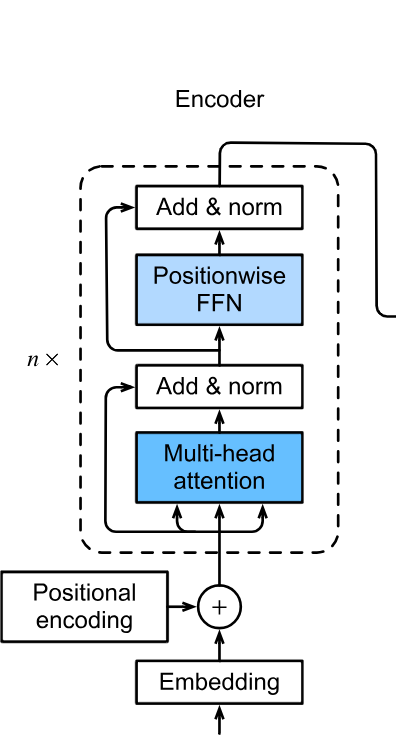

Tips in completing this section

* We will use the LSTM Encoder as input embedding.
* How many multi-head attention modules do we have.
* Can you seperate the encoder layer from the whole encoder architecture ?
* How do  we implement skip  connections
* How many layer norms do we have ?

## Transformer Encoder

In [ ]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(num_heads, d_model, dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)

    def forward(self, inp):

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        ''' TODO '''
        mha_out1, attn1 = self.mha(inp, inp, inp)

        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''
        ffn_out = self.ffn(mha_out1)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        ''' TODO '''
        out1 = self.dropout1(ffn_out)
        out1 += inp

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        out1 = self.layernorm1(out1)

        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''
        ffn_out2 = self.ffn(out1)

        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ''' TODO '''
        out2 = self.dropout2(ffn_out2)
        out2 += out1

        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        output = self.layernorm2(out2)

        return output

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_dim, 256, dropout) #torch.nn.Embedding(input_dim, d_model)
        self.projection     = torch.nn.Linear(1024, d_model)
        self.pos_encoding   = PositionalEncoding(d_model)

        self.num_layers     = num_layers

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''
        out, enc_lens = self.embedding(x, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''
        out = self.projection(out)

        # apply Positional Encoding on these extracted features
        ''' TODO '''
        out = self.pos_encoding(out)

        # apply dropout as regularization technique
        ''' TODO '''
        out = self.dropout(out)

        # passing inputs through Transformer Encoder blocks
        for i in range(self.num_layers):
            out = self.enc_layers[i](out)

        # # Layer Normalization
        # ''' TODO '''
        # output = self.layernorm(out)

        # return output

        return out, enc_lens

In [ ]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        # self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                              #  mfcc_max_seq_length,  dropout)
        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                               dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [ ]:
full_model = FullTransformer(
input_dim                   = config["input_dim"],
enc_num_layers              = config["enc_num_layers"],
dec_num_layers              = config["dec_num_layers"],
enc_num_heads               = config["enc_num_heads"],
dec_num_heads               = config["dec_num_heads"],

d_model                     = config["d_model"],
d_ff                        = config["d_ff"],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config["enc_dropout"],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

In [ ]:
### Load your best P1 model checkpoint
model.load_state_dict(torch.load('/content/checkpoints-basic-transformer/checkpoint-epoch-49.pth')['model_state_dict'])

<All keys matched successfully>

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 0.1597	 Train Perplexity 1.1735	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:18<51:01, 18.22s/it, running_distance=34.2500]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL PORTS EGGAES SIS SAIR A COONED OF


Val:   1%|          | 2/169 [00:19<23:23,  8.40s/it, running_distance=22.9062]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:22<15:46,  5.70s/it, running_distance=19.4583]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  WHATLY HIS HEART LUNGS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:23<10:44,  3.91s/it, running_distance=17.5625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT AN ABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 16.2625


Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 0.1440	 Train Perplexity 1.1551	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 0.1353	 Train Perplexity 1.1451	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:14<40:23, 14.43s/it, running_distance=29.8750]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SHEGGY SIS SAIR A COON DOV


Val:   1%|          | 2/169 [00:15<19:05,  6.86s/it, running_distance=19.9375]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:18<13:32,  4.89s/it, running_distance=17.5625]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART LUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:19<09:25,  3.42s/it, running_distance=15.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT AN ABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 14.6375


Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 0.1280	 Train Perplexity 1.1367	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 0.1220	 Train Perplexity 1.1300	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:18<50:58, 18.20s/it, running_distance=33.6250]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSED PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SEGGYS SIS SAIR A COONGED OF


Val:   1%|          | 2/169 [00:19<23:19,  8.38s/it, running_distance=21.6875]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALL GO HESITATED


Val:   2%|▏         | 3/169 [00:22<15:52,  5.74s/it, running_distance=18.8750]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  QUALLY HIS HEART RELUNS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:23<10:38,  3.87s/it, running_distance=17.3438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NEIGHBLES SOMEN IN A TRANCE TO HULDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 15.9750


Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.1165	 Train Perplexity 1.1237	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.1118	 Train Perplexity 1.1184	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:18<50:49, 18.15s/it, running_distance=32.2500]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME A FIDDLE WITHOUT A BOW ALL POOR SHEGGIES SIS SAIR A COONGED OF


Val:   1%|          | 2/169 [00:19<23:18,  8.38s/it, running_distance=21.0625]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALO GO HESTITATED


Val:   2%|▏         | 3/169 [00:22<15:42,  5.68s/it, running_distance=17.9792]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY IS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:23<10:44,  3.91s/it, running_distance=16.4219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THAT A NEIGHBLES SOMEONE IN A TRANCE TO HOLDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 15.2375


Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.1071	 Train Perplexity 1.1132	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.1029	 Train Perplexity 1.1086	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:06<17:33,  6.27s/it, running_distance=20.8750]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSED PRINCES HAS BECOME A FIDDLE WITHOUT A BOW ALL PORTS SEGGES HIS SAIR A COOLINGED OF


Val:   1%|          | 2/169 [00:07<09:40,  3.47s/it, running_distance=15.3125]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALL GO HENSITATED


Val:   2%|▏         | 3/169 [00:10<08:24,  3.04s/it, running_distance=14.5208]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELANS WORKED ON AT A STRONG MISURE GREAT


Val:   2%|▏         | 4/169 [00:11<06:20,  2.31s/it, running_distance=14.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT AN ABLES SOMEN IN A TRANCE TO HULDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 13.2250


Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.0994	 Train Perplexity 1.1047	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.0954	 Train Perplexity 1.1002	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:18<51:07, 18.26s/it, running_distance=31.6875]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME A FITTLE WITHOUT A BOW ALL POOR SHEGGIES SIS SAIR A COON DOVE


Val:   1%|          | 2/169 [00:19<23:20,  8.39s/it, running_distance=20.9062]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALLER GO HENSITATED


Val:   2%|▏         | 3/169 [00:22<15:47,  5.71s/it, running_distance=18.1042]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RULUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:23<10:49,  3.94s/it, running_distance=16.5625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HULDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 15.3750


Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.0919	 Train Perplexity 1.0964	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.0889	 Train Perplexity 1.0931	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:04<13:47,  4.92s/it, running_distance=24.0000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSE PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL POOR SHEGGIES SIT SAIR A COONED OF


Val:   1%|          | 2/169 [00:06<08:09,  2.93s/it, running_distance=17.4375]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALO GO HESSITATED


Val:   2%|▏         | 3/169 [00:08<07:32,  2.73s/it, running_distance=15.7083]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:10<05:50,  2.12s/it, running_distance=14.6406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEN IN A TRANCE TO HULDESBODY STIFF AND UNSUMPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 13.7625


Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.0857	 Train Perplexity 1.0896	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.0825	 Train Perplexity 1.0861	 Learning Rate 0.0001


Val:   1%|          | 1/169 [00:08<23:02,  8.23s/it, running_distance=21.5000]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONQUERING THE LOVELY ROSE PRINCES HAS BECOME OF FIDDLE WITHOUT A BOW ALL PORTS EGGYS SIS SAIR A COONED OF


Val:   1%|          | 2/169 [00:09<11:59,  4.31s/it, running_distance=15.6562]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALL GO HESITATED


Val:   2%|▏         | 3/169 [00:12<09:42,  3.51s/it, running_distance=14.5833]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNGS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:08,  2.60s/it, running_distance=13.8750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINK THAT A NEIGHBLES SOMEONE IN A TRANCE TO HOLDESBODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS



Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Levenshtein Distance 13.0125


Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.0797	 Train Perplexity 1.0831	 Learning Rate 0.0001
Saved epoch model


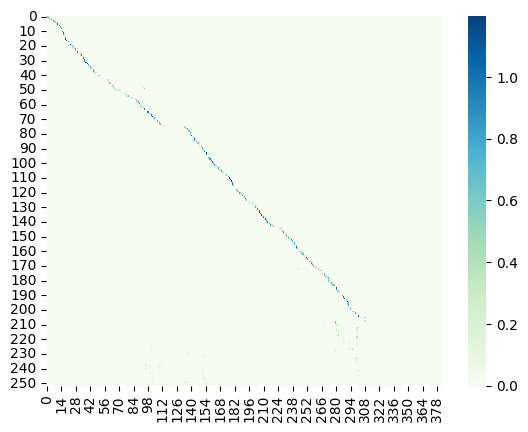

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    if epoch == 15:
        break

    if train_loss <= best_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
validate_full(full_model, val_loader)

Val:   1%|          | 1/169 [00:07<21:32,  7.69s/it, running_distance=23.7500]


Ground Truth :  BECAUSE YOU WERE SLEEPING INSTEAD OF CONQUERING THE LOVELY ROSE PRINCESS HAS BECOME A FIDDLE WITHOUT A BOW WHILE POOR SHAGGY SITS THERE A COOING DOVE
Prediction   :  BECAUSE YOUR IS SLEEPING IN SON OF CONCRING THE LOVELY ROSE PRINCES HAS BECOME OF FITTLE WITHOUT A BOW ALL POOR SEGGYS SIS SAIR A COONED OF


Val:   1%|          | 2/169 [00:09<11:22,  4.08s/it, running_distance=17.0625]


Ground Truth :  KALIKO HESITATED
Prediction   :  CALOR GO HENSITATED


Val:   2%|▏         | 3/169 [00:11<09:24,  3.40s/it, running_distance=15.2917]


Ground Truth :  ONLY HIS HEART AND LUNGS WORKED ON AT A STRONG MEASURED RATE
Prediction   :  ONLY HIS HEART RELUNS WORKED ON AT A STRONG MISSURE GREAT


Val:   2%|▏         | 4/169 [00:13<07:02,  2.56s/it, running_distance=14.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NEIGHBLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   3%|▎         | 5/169 [00:15<07:00,  2.56s/it, running_distance=13.7000]


Ground Truth :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDER WAY THE SCENE BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND
Prediction   :  WHEN THEY ENTERED THE STAGE BOX ON THE LEFT THE FIRST ACT WAS WELL UNDERWAY THE SEA BEING THE INTERIOR OF A CABIN IN THE SOUTH OF IRELAND


Val:   4%|▎         | 6/169 [00:17<06:24,  2.36s/it, running_distance=12.6354]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  IT A MOMENT PEGGY WAS ON THE STAGE AGAIN AN ALEXANDER APPLOTTED VIGOROUSLY WITH THE REST


Val:   4%|▍         | 7/169 [00:20<07:14,  2.68s/it, running_distance=12.0089]


Ground Truth :  I'LL DO ANYTHING YOU WISH ME TO BARTLEY SHE SAID TREMULOUSLY
Prediction   :  ALL'S RANYTHING YOU WISH BE TOO BARTLY SHE SAID TRUMULOUSLY


Val:   5%|▍         | 8/169 [00:22<06:04,  2.26s/it, running_distance=10.8828]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORDS YOU HAPPY THEN AT ALL


Val:   5%|▌         | 9/169 [00:22<04:34,  1.72s/it, running_distance=10.0347]


Ground Truth :  DON'T CRY DON'T CRY HE WHISPERED
Prediction   :  DON'T CRY DON'T CRY HE WHISPERED


Val:   6%|▌         | 10/169 [00:25<05:41,  2.15s/it, running_distance=9.3688]


Ground Truth :  I'VE BEEN UP IN CANADA WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE
Prediction   :  I'VE BEEN UP AND CANNOD OF WITH MY BRIDGE AND I ARRANGED NOT TO COME TO NEW YORK UNTIL AFTER YOU HAD GONE


Val:   7%|▋         | 11/169 [00:31<08:35,  3.26s/it, running_distance=9.2727]


Ground Truth :  MANY AMONG THE GENTILE PROSELYTES REFUSED TO BELIEVE THAT A CELESTIAL SPIRIT AN UNDIVIDED PORTION OF THE FIRST ESSENCE HAD BEEN PERSONALLY UNITED WITH A MASS OF IMPURE AND CONTAMINATED FLESH AND IN THEIR ZEAL FOR THE DIVINITY THEY PIOUSLY ABJURED THE HUMANITY OF CHRIST
Prediction   :  MANY AMONG THE GENTILE PRESOLATES REFUSED TO BELIEVE THAT A SALASTIAL SPIRITS AND UNDIVIDED AND PORTION OF THE FIRST ESSENCE HAD BEEN PERSONALLY UNITED WITH A MASS OF IMPURE AND CONSIMINATED FLESH AND IN THEIR ESEAL FOR THE DIVINITY THEY PIOUSLY OBJURED THE HUMANITY OF CHRIST


Val:   7%|▋         | 12/169 [00:36<09:37,  3.68s/it, running_distance=10.4375]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENNEL HES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SIS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   8%|▊         | 13/169 [00:40<10:02,  3.86s/it, running_distance=10.9808]


Ground Truth :  THE PAST HE REGRETTED HE WAS DISCONTENTED WITH THE PRESENT AND THE FUTURE HE HAD REASON TO DREAD THE ORIENTAL BISHOPS SUCCESSIVELY DISENGAGED THEIR CAUSE FROM HIS UNPOPULAR NAME AND EACH DAY DECREASED THE NUMBER OF THE SCHISMATICS WHO REVERED NESTORIUS AS THE CONFESSOR OF THE FAITH
Prediction   :  THE PAST HE REGRETTED HE WAS DISCONTENTED WITH THE PRESENCE AND THE FUTURE HE HAD REASON TO DREAD THE ORIENTAL BUSHIPS SUCCESSIVELY DISS ENGAGED THEIR CAUSE FROM HIS UNPOPULAR NAME AND EACH DAYED ACREASED THE NUMBER OF THE SKISMATICS TO REVEARED MISTORIOUS AS THE CONFESSOR OF THE FAITH


Val:   8%|▊         | 14/169 [00:45<10:26,  4.04s/it, running_distance=11.1429]


Ground Truth :  COSETTE WAS NO LONGER IN RAGS SHE WAS IN MOURNING
Prediction   :  COSETTE WAS NO LONGER IN RIGHTS SHE WAS IN MORNING


Val:   9%|▉         | 15/169 [00:49<10:30,  4.09s/it, running_distance=11.7458]


Ground Truth :  SHE WOULD NOT SPEAK THOUGH WE DANCED A WEEK WITH HER THOUGHTS A THOUSAND LEAGUES OVER THE WATER SINGER SINGER WANDERING SINGER O MY HONEY SWEET SINGER
Prediction   :  SHE WOULD NOT SPEAK THAT WE DANCED TOPY WITH HER THOUGHTS A THOUSAND LEAGUES OVERED THE WATER SINGER OH MY HINEY SWEET SINGER OH MY HINEY SWEET SINGER


Val:   9%|▉         | 16/169 [00:52<09:46,  3.83s/it, running_distance=12.1172]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FEET RANGE WATER LAST LONGER AND ESCHEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  10%|█         | 17/169 [00:56<10:05,  3.99s/it, running_distance=12.0110]


Ground Truth :  THE LONG PEPPER IS LESS AROMATIC THAN THE BLACK BUT ITS OIL IS MORE PUNGENT
Prediction   :  THE LONG PEPPER HIS LESS EREMATIC THAN THE BLACK BUT ITS VOIL AS MORE PUNGENT


Val:  11%|█         | 18/169 [01:01<10:50,  4.31s/it, running_distance=12.3056]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  THE LEMON WAS FIRST CULTIMATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTRY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES


Val:  11%|█         | 19/169 [01:03<08:23,  3.36s/it, running_distance=11.9671]


Ground Truth :  SUFFICIENT TO SERVE WITH FIVE OR SIX MACKEREL
Prediction   :  OF SUFFICIENT TO SERVE WITH FIVE OR SIX MACREL


Val:  12%|█▏        | 20/169 [01:06<08:11,  3.30s/it, running_distance=11.8906]


Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE EDDER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVERT LET IT'S DUENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL


Val:  12%|█▏        | 21/169 [01:09<07:49,  3.17s/it, running_distance=11.7083]


Ground Truth :  NOW WHY IS THAT OTTO
Prediction   :  NOW WISE THAT ARTO


Val:  13%|█▎        | 22/169 [01:11<07:25,  3.03s/it, running_distance=11.4403]


Ground Truth :  WE STOOD PANTING ON THE EDGE OF THE RAVINE LOOKING DOWN AT THE TREES AND BUSHES THAT GREW BELOW US
Prediction   :  WE STOOD PANTING ON THE EDGE OF THE REVENE LOOKING DOWN AT THE TREES AND WHICHES A GREW ALO US


Val:  14%|█▎        | 23/169 [01:16<08:47,  3.61s/it, running_distance=11.4918]


Ground Truth :  I DO NOT BELIEVE IN SUCH REPUBLICS ANY MORE THAN IN THAT OF PLATO OR IF THE THINGS WE READ OF REALLY HAPPENED I DO NOT HESITATE TO AFFIRM THAT THESE SUPPOSED DEMOCRACIES WERE COMPOSED OF VERY DIFFERENT ELEMENTS FROM OURS AND THAT THEY HAD NOTHING IN COMMON WITH THE LATTER EXCEPT THEIR NAME
Prediction   :  I DIDN'T BOTH EVEN SUCH REPUBLICS ANY MORE THAT IN THAT OF PLATEL OR IF THE THINGS WE READ OFF A REALLY HAPPENED I DO NOT HESITATES TO FUM A THESE SUPPOSED DEMOCRACIES WERE COMPOSE OF THE FAIRY DIFFERENT ELEMENTS FROM HOURS AND IT THEY HAD NOTHINGING COMMON WITH THE LETTLE EXCEPT THEIR NAME


Val:  14%|█▍        | 24/169 [01:23<10:53,  4.51s/it, running_distance=11.9714]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALTIE ALSER ENGLISH IN FRENCH MUSIC THESE NORTHS


Val:  15%|█▍        | 25/169 [01:24<08:13,  3.43s/it, running_distance=11.9250]


Ground Truth :  IT'S THE FIRST TIME HILDA HAS BEEN TO OUR HOUSE AND TOM INTRODUCES HER AROUND
Prediction   :  IT'S A FIRST TIME HILD A HAS BEEN TO OUR HOUSE AND TON THE TRODUCES HER AROUND


Val:  15%|█▌        | 26/169 [01:28<08:39,  3.63s/it, running_distance=12.2067]


Ground Truth :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU
Prediction   :  IS THERE ANY CHANCE FOR THE OTHER ONE THINK YOU


Val:  16%|█▌        | 27/169 [01:32<08:46,  3.70s/it, running_distance=12.0532]


Ground Truth :  I CANNOT THINK WHAT POSSESSES ME THAT I MUST ALWAYS BE WANTING TO COMFORT HIM WHEN HE'S DOWNCAST AND THAT I MUST GO MEDDLING WI HIM TO NIGHT WHEN SURE ENOUGH IT WAS HIS AUNT'S PLACE TO SPEAK TO HIM
Prediction   :  I CANNOT THINK WHAT POSSESSES ME THAT I MUST ALWAYS BE WANTING TO COMFORT HIM WHEN HE'S DOWN CAST AND THAT I MUST GO METTLING WITH HIM TO NIGHT WHEN SURE ENOUGH IT WAS HIS AUNT'S PLACE TO SPEAK TO HIM


Val:  17%|█▋        | 28/169 [01:35<08:35,  3.66s/it, running_distance=11.9286]


Ground Truth :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INCHES HIGH AND STIFF ENOUGH TO STAND ALONE
Prediction   :  FROM UNDER THE LINING HE NOW PRODUCED A COLLECTION OF BRILLIANTLY COLORED PAPER FIGURES SEVERAL INJUST HIGH AND STIFFING OFF TO STAND ALONE


Val:  17%|█▋        | 29/169 [01:40<09:12,  3.94s/it, running_distance=11.7478]


Ground Truth :  THEY BEGAN TO LAUGH BOISTEROUSLY WHEN THEY SAW ME CALLING
Prediction   :  THEY BEGAN TO LAUGH BOISTRESSLY WHEN THEY SAW ME CALLING


Val:  18%|█▊        | 30/169 [01:41<07:22,  3.18s/it, running_distance=11.7417]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  HE COULD STAND RIGHT UP AND TOPPED YIEL HE GOOD DID HE FIGHT HARD


Val:  18%|█▊        | 31/169 [01:44<07:06,  3.09s/it, running_distance=11.5585]


Ground Truth :  ANTONIA'S FATHER UNCOVERED ONE OF HIS LONG BONY LEGS AND RUBBED IT RHYTHMICALLY
Prediction   :  AND STEE AS FATHER UNCOVERED ONE OF HIS LONG BONY LEGS AND BROBBED IT WRITHNICKLY


Val:  19%|█▉        | 32/169 [01:46<06:07,  2.68s/it, running_distance=11.3594]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  20%|█▉        | 33/169 [01:49<06:20,  2.80s/it, running_distance=11.2992]


Ground Truth :  LIKE THE TWO KINGS OF SPARTA THEY REIGNED JOINTLY DIVIDING BETWEEN THEM THE LABOURS AND CARES OF STATE
Prediction   :  LIKE THE TWO KINGS OF SPARTA THEY RAVING JOINTLY DIFIDING BETWEEN THEM THE LABOURS AND CARES OF STEEK


Val:  20%|██        | 34/169 [01:56<09:12,  4.09s/it, running_distance=11.5919]


Ground Truth :  SEVENTEEN SEVENTEEN
Prediction   :  SEVENTEEN SEVENTEEN


Val:  21%|██        | 35/169 [02:04<11:20,  5.08s/it, running_distance=12.1250]


Ground Truth :  MAIZE NEXT TO WHEAT AND RICE MAIZE IS THE GRAIN MOST USED IN THE NOURISHMENT OF MAN
Prediction   :  MAZE NEXT TO WEED IN RICE MAZES THE GRAIN MOST USED IN THE NOURISHMENT OF MAN


Val:  21%|██▏       | 36/169 [02:10<12:19,  5.56s/it, running_distance=12.1024]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  HE SAYS THAT BY CUTTING THROUGH FOUR FIVE SLICES AT A TIME ALL THE BUTTER IS SCLEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LEQUID


Val:  22%|██▏       | 37/169 [02:15<11:33,  5.25s/it, running_distance=11.9764]


Ground Truth :  ILLUSTRATION RUSKS
Prediction   :  ILLUSTRATION RUSKS


Val:  22%|██▏       | 38/169 [02:21<11:56,  5.47s/it, running_distance=12.1530]


Ground Truth :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACE BESIDES IN CONSEQUENCE OF TOO STRICT A WATCHFULNESS TO KEEP IT PURE
Prediction   :  IT WAS EVIDENT THAT THE RACE HAD DEGENERATED LIKE MANY A NOBLE RACED BESIDES IN CONSEQUENCE OF TWO STRICK TO WATCHFULNESS TO KEEP AT PURE


Val:  23%|██▎       | 39/169 [02:27<12:10,  5.62s/it, running_distance=12.2099]


Ground Truth :  THERE IS A WONDERFUL INSIGHT IN HEAVEN'S BROAD AND SIMPLE SUNSHINE
Prediction   :  THERE IS A WONDERFUL INSIGHT IN HEAVEN'S BROAD AND SIMPLE SUNSHINE


Val:  24%|██▎       | 40/169 [02:28<09:35,  4.46s/it, running_distance=12.1375]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINTED TO GARROW TYPEST BECAUSE LIKE AN OLD LADY'S COUP OF TEAGUE IT IS WATER BEWITCHED


Val:  24%|██▍       | 41/169 [02:32<09:07,  4.28s/it, running_distance=12.0183]


Ground Truth :  THE WALLS OF THE ROOMS WERE DISCORDANTLY PAPERED
Prediction   :  THE WALLS OF THE ROOMS WERE DISCORDENTLY PAPRIED


Val:  25%|██▍       | 42/169 [02:33<07:01,  3.32s/it, running_distance=11.8914]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  HE WAS AN EFFEVOURED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE


Val:  25%|██▌       | 43/169 [02:35<05:36,  2.67s/it, running_distance=11.7776]


Ground Truth :  FORTUNATELY THERE WAS NOTHING FROM HIS WIFE EITHER
Prediction   :  FORTUNATELY THERE WAS NOTHING FROM HIS WIFE EITHER


Val:  26%|██▌       | 44/169 [02:37<05:05,  2.45s/it, running_distance=11.6364]


Ground Truth :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVE TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER ITSELF THAT HE COULD SEE HIS WAY OUT
Prediction   :  BY THE TIME HE REACHED HIS OWN STREET HE WAS KEENLY ALIVED TO THE DIFFICULTIES OF HIS SITUATION AND WISHED OVER AND OVER THAT SOME SOLUTION WOULD OFFER IN THESELF THAT HE COULD SEE HIS WAY OUT


Val:  27%|██▋       | 45/169 [02:39<04:48,  2.33s/it, running_distance=11.5583]


Ground Truth :  FOR RELIEF HE AROSE AND JOINED IN CONVERSATION WITH A FEW FRIENDS WHO WERE DRINKING
Prediction   :  FULL RELIEF HE AROUSE AND JOINED IN THE CONVERSATION WITH A FEW FRANCE HE WERE DRINKING


Val:  27%|██▋       | 46/169 [02:40<04:18,  2.10s/it, running_distance=11.5122]


Ground Truth :  HE DID MANAGE TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRIE BUT WHEN HE GOT IN OGDEN PLACE HE THOUGHT HE SAW A MAN WATCHING HIM AND WENT AWAY
Prediction   :  HE DID MANAGED TO BRING HIMSELF INTO THE MOOD TO GO OUT TO CARRY BUT WHEN HE THOUGHT HE SOUGHT MAN MATCHING HIM AND MET AWAY


Val:  28%|██▊       | 47/169 [02:43<04:58,  2.45s/it, running_distance=11.5944]


Ground Truth :  I MUST NOT CONCLUDE WITHOUT EXPRESSING MY MOST SINCERE THANKS TO MY CRITICS AND TO THE PUBLIC FOR THE LENIENCY AND CONSIDERATION WITH WHICH THEY HAVE TREATED MY ADVENTURES
Prediction   :  I MUST NOT THINK LED WITHOUT EXPRESSING MY MOST INCERED THANKS TO MY CRITICS AND TO THE PUBLIC FOR THE LANIANCY AND CONSIDERATION WITH WHICH THEY HAVE TREATED MY FENTURES


Val:  28%|██▊       | 48/169 [02:50<07:43,  3.83s/it, running_distance=11.7604]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  I WAS TO SEE THE SHEEP NONNESS AS AIRLY CLOSE AT HAND OR TO GET THE MINUS INGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE RONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT HIM OF EIGHT HUNDRED OF THEM AND BEING ALL BREATING USE THEY WERE PRETTY QUIET


Val:  29%|██▉       | 49/169 [02:52<06:25,  3.21s/it, running_distance=11.7972]


Ground Truth :  THEIR EXPRESSION WAS DIVINE AND AS THEY GLANCED AT ME TIMIDLY BUT WITH PARTED LIPS IN GREAT BEWILDERMENT I FORGOT ALL THOUGHTS OF THEIR CONVERSION IN FEELINGS THAT WERE FAR MORE EARTHLY
Prediction   :  THEIR EXPESSION WAS DIVINE AND AS THEY GLANCE IT ME IT LEAVES INGREATED THE WILDERMAND I FORGOT ALL THOUGHTS OF THEIR CONVERSION IN FEELINGS THAT WERE FARM ARTHLY


Val:  30%|██▉       | 50/169 [02:57<07:07,  3.59s/it, running_distance=11.8525]


Ground Truth :  THE DESIGN WAS DIFFERENT BUT THE THING WAS CLEARLY THE SAME
Prediction   :  THAT HIS EYE WAS DIFFERAM BUT THE THING WAS CLAIRLY THE SAME


Val:  30%|███       | 51/169 [02:59<06:16,  3.19s/it, running_distance=11.7941]


Ground Truth :  I EVEN BOUGHT SOMETHING FOR MADGE I MEAN MISSUS WILSON
Prediction   :  I EVEN BOUGHT SOMETHING FROM EDGE I MEAN MISSUS WILSON


Val:  31%|███       | 52/169 [03:01<05:49,  2.99s/it, running_distance=11.6562]


Ground Truth :  THERE APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY
Prediction   :  THEY APPEARED TO BE NO KNOCKER THOUGH WHETHER IT HAD BEEN TWISTED OFF WAS MORE THAN I COULD SAY


Val:  31%|███▏      | 53/169 [03:05<06:04,  3.14s/it, running_distance=11.5248]


Ground Truth :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT WEEK OR THE WEEK AFTER CERTAINLY AT THE EARLIEST POSSIBLE MOMENT AND I SHOULDN'T BE AT ALL SURPRISED TO LEARN THAT ALL MARY ANN'S THINGS HAD BEEN ALREADY BOUGHT AND PERHAPS SOME OF THEM MARKED
Prediction   :  I DO NOT KNOW WHEN IT IS GOING TO BE BUT IT WILL BE EITHER NEXT WEEK OR THE WEEK AFTER CERTAINLY AT THE EARLIEST POSSIBLE MOMENT AND I SHOULDN'T BE AT ALL SURPRISED TO LEARN THAT ALL MARY ENDS THINGS HAVE BEEN ALREADY BOUGHT AND PRAPS SOME OF THEM MARKED


Val:  32%|███▏      | 54/169 [03:06<05:05,  2.66s/it, running_distance=11.3762]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  IT TURNED OUT THAT SHE HAVE A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR


Val:  33%|███▎      | 55/169 [03:08<04:18,  2.27s/it, running_distance=11.2886]


Ground Truth :  THAT WAS WHAT MISSUS MACPHERSON SAID TO ME ONLY THE OTHER DAY
Prediction   :  THAT WAS WHAT MISSUS MICK FIERCEN SAID TO ME ONLY THE OTHER DAY


Val:  33%|███▎      | 56/169 [03:09<03:52,  2.06s/it, running_distance=11.2031]


Ground Truth :  THIS MAN WAS CLAD IN A BROWN CAMEL HAIR ROBE AND SANDALS AND A GREEN TURBAN WAS ON HIS HEAD
Prediction   :  THIS MEN WAS CLED IN A BROWN CAMPEL HERE ROBE AND SANDALS AND A GREEN TURBIN WAS ON HIS HEAD


Val:  34%|███▎      | 57/169 [03:11<03:28,  1.86s/it, running_distance=11.1458]


Ground Truth :  YOU HAVE NEVER DISOBEYED ME OBEY MY LAST COMMAND
Prediction   :  I'VE NEVER DISOBLAYED ME OH BAY MY LAST COMMAN


Val:  34%|███▍      | 58/169 [03:15<04:47,  2.59s/it, running_distance=11.2241]


Ground Truth :  YES CHARCOAL
Prediction   :  YES JARKOLL


Val:  35%|███▍      | 59/169 [03:18<04:53,  2.66s/it, running_distance=11.1727]


Ground Truth :  BUD THREW UP HIS ARMS TO PROTECT HIMSELF BUT TOO LATE
Prediction   :  BUT THROUGH UPPESARMS TO PRODECT HIMSELF BUT TWO LATE


Val:  36%|███▌      | 60/169 [03:19<04:02,  2.23s/it, running_distance=11.1083]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF


Val:  36%|███▌      | 61/169 [03:22<04:08,  2.30s/it, running_distance=11.0441]


Ground Truth :  THINK OF LADY GLENARVAN THINK OF MARY GRANT
Prediction   :  THINK OF LIGHTY CALL AT NORBIN THINK OF MARY GRAND


Val:  37%|███▋      | 62/169 [03:23<03:33,  1.99s/it, running_distance=11.0484]


Ground Truth :  ON THAT SIDE DESCENT WAS IMPOSSIBLE AND HAD IT BEEN POSSIBLE THE BOTTOM WAS SHUT IN BY THE ENORMOUS ROCK
Prediction   :  ON THAT SIDE DESCENT WAS IN TOSSIP AND HAD IT BEEN POSSIBLE BOTTOM WAS SHUT IN BY THE ENORMERS WERE ALK


Val:  37%|███▋      | 63/169 [03:27<04:49,  2.73s/it, running_distance=11.1458]


Ground Truth :  THE ENTRANCE IS LIGHT BECAUSE IT OPENS SO WIDE BUT WE CAN SEE THAT THE FLOOR SLOPES DOWNWARD AND THE WAY LOOKS DARK AND NARROW BEFORE US
Prediction   :  THE ANTRANCE'S LIGHT BECAUSE IT OPEN SO WIDE BUT WE CAN SEE THAT THE FLOOR SLOPED DOWN WORD AND THE WAY LOOKS DARKED AND NARROW BEFORE US


Val:  38%|███▊      | 64/169 [03:32<05:50,  3.34s/it, running_distance=11.3848]


Ground Truth :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF IMMORALITY ATTACHES EITHER TO THE HEROINE OF THIS BOOK OR TO THE LEADING PHILOSOPHERS OF HER SCHOOL FOR SEVERAL CENTURIES
Prediction   :  NOT BE IT EVER REMEMBERED THAT THE SLIGHTEST SUSPICION OF THE MORALITY ATTACHES ARE EIGHTHER TO THE HAIR OF WIN OUT THIS BOOK OR TO THE LEADING FALOSOPHERS OVER SCHOOL FOR SENTURES


Val:  38%|███▊      | 65/169 [03:40<08:06,  4.68s/it, running_distance=12.3510]


Ground Truth :  THAT WONDERFUL METAPHYSIC SUBTLETY WHICH IN PHRASES AND DEFINITIONS TOO OFTEN UNMEANING TO OUR GROSSER INTELLECT SAW THE SYMBOLS OF THE MOST IMPORTANT SPIRITUAL REALITIES AND FELT THAT ON THE DISTINCTION BETWEEN HOMOOUSIOS AND HOMOIOUSIOS MIGHT HANG THE SOLUTION OF THE WHOLE PROBLEM OF HUMANITY WAS SET TO BATTLE IN ALEXANDRIA THE ANCIENT STRONGHOLD OF GREEK PHILOSOPHY WITH THE EFFETE REMAINS OF THE VERY SCIENTIFIC THOUGHT TO WHICH IT OWED ITS EXTRAORDINARY CULTURE
Prediction   :  THAT WONDERFUL METAPHYSIC SUFFILTY WHICH IN FRACES AND DEFINITIONS TO OFTEN UNMEANING TO HOUR A GROSE OR INTELLECT SAW AT THE SIMBLES OF THE MOST IMPORTANT SPIRITUAL REALITIES AND FELT THAT ON THE DISTINCTION BETWEEN HOME OF LOSIUS AND HOME OF LOSIUS AND HOME OF LOSIUS AND HOME OF LOSIUS AND HOME OF LOSIUS AND HOME OF LOSIUS AND HORA


Val:  39%|███▉      | 66/169 [03:56<13:52,  8.08s/it, running_distance=12.5985]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  NOT THAT SUNCHER CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE AND MOVED MY EQUINIMITY BUT IF I COULD STOOP TO PATE I SHOULD HATE HER HATE HER


Val:  40%|███▉      | 67/169 [04:00<11:32,  6.79s/it, running_distance=12.6287]


Ground Truth :  THEN THE SHINING OF THE WET LEAVES IS DELIGHTFUL AND THE STEAMY FRAGRANCE AND THE BURST OF BIRD SONG FROM A MULTITUDE OF THRUSHES AND FINCHES AND WARBLERS THAT HAVE NESTS IN THE CHAPARRAL
Prediction   :  THEN THE SHUNNING OF THE WED LEAVES IS DELIFEL AND THE STEAMY FRIGORANCE AND THE BURST OF BIRDS SONG FROM A MULTITUDE OF THRUSHES AND FINCHES AND WARBLERS THAT HAVE NESTS IN THE SHEPPERO


Val:  40%|████      | 68/169 [04:03<09:54,  5.88s/it, running_distance=12.6434]


Ground Truth :  BUT NEITHER THE GLORIFIED WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST HOLD THE EYE
Prediction   :  BENEATHED THE GLORIFITE WOODS ON THE ONE HAND NOR THE LAKE ON THE OTHER COULD AT FIRST COLD THE EYE


Val:  41%|████      | 69/169 [04:10<09:55,  5.95s/it, running_distance=12.8034]


Ground Truth :  THE BIG MEADOWS LIE NEAR THE FOOT OF LASSEN'S BUTTE A BEAUTIFUL SPACIOUS BASIN SET IN THE HEART OF THE RICHLY FORESTED MOUNTAINS SCARCELY SURPASSED IN THE GRANDEUR OF ITS SURROUNDINGS BY TAHOE
Prediction   :  THE BAKE MENNOWS LINE NEAR THE FOOT OF LASTEN'S BEAUT A BEAUTIFUL SPACIOUS PACION SAID IN THE HART OF THE RICHLY FORESTED MOUNTAINS SCARCELY SURPASSED IN THE GRANDER OF ITS SURROUNDINGS BY TAU


Val:  41%|████▏     | 70/169 [04:11<07:40,  4.65s/it, running_distance=12.7652]


Ground Truth :  I INQUIRED OF GEORGE WITH MY EYES STILL ON THIS FURTIVE WATCHER
Prediction   :  WHY INQUIRED OF GEORGE WITH MY EYES AND STILL ON THIS FURTITH AND WATCHER


Val:  42%|████▏     | 71/169 [04:12<05:55,  3.63s/it, running_distance=12.7271]


Ground Truth :  THE SUGGESTION HE HAD LAUGHED AT WAS NOT SO ENTIRELY FOOLISH AS HE HAD BEEN PLEASED TO CONSIDER IT
Prediction   :  THE SUGGESTION HE HAD A LAUGH DAD WAS NOT SO ENTERLY FOOLISH AS HE HAD BEEN ABLEASED TO CONSIDERATINGEN


Val:  43%|████▎     | 72/169 [04:15<05:12,  3.23s/it, running_distance=12.6623]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  THIS SWEET WATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTTER JASE AND MORE OR LESS ALATHAVORITCH


Val:  43%|████▎     | 73/169 [04:16<04:17,  2.68s/it, running_distance=12.6164]


Ground Truth :  NOT TILL THE DOCTOR CAME HER DOCTOR WHO WAS HAPPILY IN HIS OFFICE IN THIS VERY BUILDING
Prediction   :  NOT TILL THE DARGER CAME HER DOG DREW WITH HAPPLY IN HIS OFFICE AND THIS VERY BUILDING


Val:  44%|████▍     | 74/169 [04:18<03:38,  2.29s/it, running_distance=12.5853]


Ground Truth :  MISS CLARKE STARTED AND HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY DID I SHE QUERIED MUSINGLY
Prediction   :  THIS CLARK STARTED BEEN AT HER SWEET FACE SHOWED A MOMENT'S PERPLEXITY END ONCE SHE QUARRIED AM USINGLY


Val:  44%|████▍     | 75/169 [04:24<05:32,  3.53s/it, running_distance=12.7375]


Ground Truth :  BESIDES I WAS OF OPINION THAT A MAN'S PROFESSION WHATEVER IT MIGHT BE OUGHT TO SUPPLY HIM WITH ENOUGH MONEY TO SATISFY ALL HIS WANTS AND THE VERY POOR PAY OF AN OFFICER WOULD NEVER HAVE BEEN SUFFICIENT TO COVER MY EXPENSES BECAUSE MY EDUCATION HAD GIVEN ME GREATER WANTS THAN THOSE OF OFFICERS IN GENERAL
Prediction   :  BESIDES OH WAS OF OPINION THAT A MAN'S PROFESSION WHATEVER IT MY BE OUGHT TO SUPPLY HIM WITH ENOUGH MONEY TO SATISFY ALL HIS ONCE AND BE VERY POOR PAY OF AN OFFICER WOULD NEVER HAVE BEEN SUPPICION TO COVER MY EXPENSES BECAUSE MY EDUCATION HAD GIVEN ME GREATER ONCE THAN THOSE OF OPPOSSORS AND GENERAL


Val:  45%|████▍     | 76/169 [04:29<06:06,  3.94s/it, running_distance=12.6891]


Ground Truth :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDED IT TO HIM
Prediction   :  I PICKED IT UP AND COMING UP TO HIM JUST AS HE WAS GOING DOWN THE STEPS I HANDLED TO HIM


Val:  46%|████▌     | 77/169 [04:33<05:54,  3.86s/it, running_distance=12.6510]


Ground Truth :  HE WROTE THE QUESTION AND GAVE IT TO ME I READ IT I COULD NOT UNDERSTAND EITHER THE SUBJECT OR THE MEANING OF THE WORDS BUT IT DID NOT MATTER I HAD TO GIVE AN ANSWER
Prediction   :  HE WROTE THE QUESTION AND GAVE IT TO ME I READ IT I COULD NOT UNDERSTAND EITHER THE SUBJECT OR THE MEANING OF THE WORDS BUT IT DID NOT MATTER I HAD TO GIVE AN ANSWER


Val:  46%|████▌     | 78/169 [04:39<06:51,  4.53s/it, running_distance=12.6883]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  YET I DID THE WATCH FULL MISS WOODLY OFTEN TIMES HERE A SIGH ESCATE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVER SPREAD HER FACE


Val:  47%|████▋     | 79/169 [04:44<06:57,  4.64s/it, running_distance=12.6329]


Ground Truth :  MISS WOODLEY THOUGHT IT HER DUTY TO BE MUTE AND NOW THE GINGLE OF A TEA SPOON WAS LIKE A DEEP TONED BELL ALL WAS SO QUIET
Prediction   :  MISS WOODLY THOUGHT IT HER DUTY TO BE MUTE AND NOW THE CHINGLE OF A TEAST BOON WAS LIKE A DEEP TONE TO BELL ALL WAS SO QUIETS


Val:  47%|████▋     | 80/169 [04:46<06:03,  4.09s/it, running_distance=12.5977]


Ground Truth :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTEMPT WITH SOME ZEAL
Prediction   :  IN MAKING THIS HE HAD EXPECTED NO SUCCESS THOUGH FROM THE ENERGETIC NATURE OF HIS DISPOSITION HE HAD MADE THE ATTECT WITH SOMESEIL


Val:  48%|████▊     | 81/169 [04:50<05:56,  4.05s/it, running_distance=12.5725]


Ground Truth :  BOZZLE HAD ALWAYS WAITED UPON HIM WITH A DECENT COAT AND A WELL BRUSHED HAT AND CLEAN SHOES
Prediction   :  BOSSEL HAD ALWAYS WAITED UPON HIM WITH THE DECENT COAT AND A WELL BRUSH HATS IN CLEAN SHOES


Val:  49%|████▊     | 82/169 [04:57<06:49,  4.71s/it, running_distance=12.6075]


Ground Truth :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MONTESINOS AND SAW DULCINEA TRANSFORMED INTO A COUNTRY WENCH SKIPPING AND MOUNTING UPON HER SHE ASS AGAIN THAT THE WORDS OF THE SAGE MERLIN WERE SOUNDING IN HIS EARS SETTING FORTH THE CONDITIONS TO BE OBSERVED AND THE EXERTIONS TO BE MADE FOR THE DISENCHANTMENT OF DULCINEA
Prediction   :  AT ONE MOMENT IT SEEMED TO HIM THAT HE WAS IN THE CAVE OF MALTICINOS AND SAW DOSONANA TRANSFORMED INTO A CUTTRY WANCH SKIPPING AND MOUNTING UPON HER SHE ASKED AGAIN THAT THE WORDS OF THE SACHERMERLAND WERE SOUNDING IN HIS EARS SETTING FOR THE DISSANT CHANTMENT ALL SONAMENT A VELSE AND THE EXERTIONS TO BE MAID FOR THE DECEND ALSALE


Val:  49%|████▉     | 83/169 [05:01<06:34,  4.59s/it, running_distance=12.6220]


Ground Truth :  IN A WORD HE PLEDGED HIMSELF TO BE MINE AND I PROMISED TO BE HIS WITHOUT CARRYING MATTERS ANY FURTHER
Prediction   :  IN A WORD HE PLEDGED HIMSELF TO BE MIND AND I PROMISED TO BE HIS WITHOUT CARRYING MATTERS THANY FURTHER


Val:  50%|████▉     | 84/169 [05:11<08:53,  6.27s/it, running_distance=12.7731]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG IN AFTER DISTURB THE QUIETEST HEARTS


Val:  50%|█████     | 85/169 [05:16<08:17,  5.92s/it, running_distance=12.7338]


Ground Truth :  I ORDER YOU SIR NORTH CRIED INDIGNANT
Prediction   :  I ORDER YOU SIR NORTH CRIED INDIGNANT


Val:  51%|█████     | 86/169 [05:17<06:00,  4.34s/it, running_distance=12.6584]


Ground Truth :  KIRKLAND JUMPED FOR THE JETTY MISSED HIS FOOTING AND FELL INTO THE ARMS OF THE CHAPLAIN
Prediction   :  COURKLIN JUMPED FOR THE JEDDY MIST HIS FOOTING AND FELL UNDER THE ARMS OF THE CHAPLAIN


Val:  51%|█████▏    | 87/169 [05:17<04:18,  3.15s/it, running_distance=12.5467]


Ground Truth :  HE IS JUST MARRIED YOU KNOW IS HE SAID BURGESS
Prediction   :  HE IS JUST VARY DO KNOW IS HE SAID BURGESS


Val:  52%|█████▏    | 88/169 [05:21<04:24,  3.26s/it, running_distance=12.5135]


Ground Truth :  OUR ROADS LIE TOGETHER DOCTOR
Prediction   :  OUR ROADS LIE TOGETHERED AFTER


Val:  53%|█████▎    | 89/169 [05:23<03:48,  2.86s/it, running_distance=12.4431]


Ground Truth :  GOOD NIGHT SIR I HOPE YOU WILL BE COMFORTABLE
Prediction   :  GOOD NIGHT SIR I HOPE YOU WILL BE COMFORTABLE


Val:  53%|█████▎    | 90/169 [05:24<02:59,  2.28s/it, running_distance=12.3757]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  I'LL REPORTHUS TO THE GAVERNMENT


Val:  54%|█████▍    | 91/169 [05:25<02:41,  2.06s/it, running_distance=12.3455]


Ground Truth :  I FEEL LIKE A BOY OUT OF SCHOOL OR RATHER A MAN OUT OF PRISON AND MUST ENJOY MY LIBERTY IN SOME WAY
Prediction   :  I FEEL I CA BOY OUT OF SCHOOL OR RATHER A MAN OUT OF PRISON AND MUST ENJOY MY LIBERTY IN SOME WAY


Val:  54%|█████▍    | 92/169 [05:28<03:04,  2.39s/it, running_distance=12.3791]


Ground Truth :  HE'S A KIND NEIGHBORLY MAN AND HIS BOY WILL TAKE MY PLACE ABOUT THE HOUSE AND PROTECT YOU FAITHFULLY
Prediction   :  HE SO KINDSH NEIGHBORLY MAN AND TO SPORY WILL TAKE MY PLACE ABEL THE HOUSE AND PROTECTY FACELY


Val:  55%|█████▌    | 93/169 [05:35<04:43,  3.72s/it, running_distance=12.4933]


Ground Truth :  HIS WIFE FED HIM WITH THE FAT OF THE LAND REGARDLESS OF CONSEQUENCES HIS CHILDREN REVOLVED ABOUT HIM WITH TIRELESS CURIOSITY AND WONDER HIS NEIGHBORS FLOCKED IN TO APPLAUD ADVISE AND ADMIRE EVERY ONE TREATED HIM WITH A RESPECT MOST GRATEFUL TO HIS FEELINGS HE WAS AN OBJECT OF INTEREST AND WITH EVERY HOUR HIS IMPORTANCE INCREASED SO THAT BY NIGHT HE FELT LIKE A COMMANDER IN CHIEF AND BORE HIMSELF ACCORDINGLY
Prediction   :  HIS WIFE SAID HIM WITH THE THOUGHT OF THE LAND REGADLESS OF CONSEQUENCES HIS CHILDREN WERE VOLVED ABOUT HIM WITH TIRELESS CURIOSITY AND WONDER HIS NEIGHBORS FLOCKED INTO A PLAUD ADVICE AND ADMIRE EVERY ONE TREATED HIM WITH THE RESPECT MOST GRATEFUL TO AT HIS FEELINGS HE WAS NOBJECT OF INTEREST AND WITH EVERY OTHER HIS IMPORTANCELF ACRED


Val:  56%|█████▌    | 94/169 [05:39<04:42,  3.76s/it, running_distance=12.4867]


Ground Truth :  DAVID AND CHRISTIE WENT SMILING AWAY TOGETHER AND IF THEY SHED ANY TEARS OVER THE BRIEF HAPPINESS NO ONE SAW THEM BUT THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS
Prediction   :  DIF IT INCRISTY WENT SMILING AWAY TOGETHER AND IF THEY SHAD ANY TEARY SUFFERED THE BRIEF HAPPINESS NO ONE SAW THEM WITH THE FLOWERS AND THEY LOYALLY KEPT THE SECRET FOLDED UP IN THEIR TENDER HEARTS


Val:  56%|█████▌    | 95/169 [05:47<06:22,  5.17s/it, running_distance=12.7000]


Ground Truth :  THE MOST VARIED EXPERIENCE TEACHES IT WHAT ARE THE QUALITIES TO WHICH IT PRINCIPALLY OWES THE FACT THAT IT STILL EXISTS IN SPITE OF ALL GODS AND MEN AND HAS HITHERTO BEEN VICTORIOUS THESE QUALITIES IT CALLS VIRTUES AND THESE VIRTUES ALONE IT DEVELOPS TO MATURITY
Prediction   :  THE MOST VARIED EXPERIONS TEACHES AT WHAT BY THE QUALITIES TO WHICH IT PRINCIPALLY OSE THE FACT THAT IT STILL EXISTS IN SPITE OF ALL GODS AND MEN AND HIS SITHERTO BEN VICTORIOUS THESE QUALITIES IT CALLS VIRTUOUS A LONE AT DEVELOPS TO MATURITY


Val:  57%|█████▋    | 96/169 [05:57<08:04,  6.64s/it, running_distance=12.9395]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES POVERMISSION TO TAKE ACTION WITH THEIR BEST YOUTH AND STRENGTH FIRACTION HAVE BEEN USED UP IN THE SITTING STILL AND HOW MANY AT ONE JUST AS HE SPRANG UP HIS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMMED AND HIS SPIRITS ARE NOW TO HEAVY


Val:  57%|█████▋    | 97/169 [06:03<07:27,  6.22s/it, running_distance=13.1972]


Ground Truth :  THE HOUSE WHICH SEEMED TO CONSIST OF TWO OR THREE HIGH NARROW AND STEEP ROOFED BUILDINGS PROJECTING FROM EACH OTHER AT RIGHT ANGLES FORMED ONE SIDE OF THE INCLOSURE
Prediction   :  THE HOUSE WHICH SEEMED TO CONSIST OF TWO OR THREE HIGH NEARER AND STEEP ROOFED BUILDINGS PROJECTING FROM ENCLOS FORMED ONE SIGHT IF HE ENCLOSURE


Val:  58%|█████▊    | 98/169 [06:07<06:30,  5.50s/it, running_distance=13.2232]


Ground Truth :  THEY HELD CONVENTICLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE AND CRUELTY BY THE SCOTTISH GOVERNMENT MORE THAN ONCE TOOK ARMS DURING THOSE REIGNS
Prediction   :  THEY HOWED CONVENTABLES IN THE OPEN FIELDS AND BEING TREATED WITH GREAT VIOLENCE IN CRUELTY BY THE SCOTTISH GOVERNMENT WERE THAN ONCE TO CARNSTERING THOSE REIGNS


Val:  59%|█████▊    | 99/169 [06:09<05:18,  4.55s/it, running_distance=13.1793]


Ground Truth :  ARE YOU A GIANT
Prediction   :  ARE YOU HAD GIANT


Val:  59%|█████▉    | 100/169 [06:12<04:53,  4.25s/it, running_distance=13.1619]


Ground Truth :  YOU ARE NOT LIKE MY PEOPLE THE PINKIES AND THERE IS NO PLACE FOR YOU IN OUR COUNTRY
Prediction   :  YOU ARE NOT LIKE MY PEOPLE THE PINKEYS AND THERE IS NO PLACE FOR YOU IN OUR HUNTRY


Val:  60%|█████▉    | 101/169 [06:17<05:00,  4.43s/it, running_distance=13.1720]


Ground Truth :  IN THIS TYPE OF PRAYER THERE WAS NO BESEECHING OF FAVOR OR HELP
Prediction   :  IN THIS TYPE OF PRAYER THERE WAS NO BESEECHING OF FAVOUR OR HELP


Val:  60%|██████    | 102/169 [06:22<05:06,  4.57s/it, running_distance=13.2083]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  WHEN SHE FELL THE WHOLE RAYS FELL WITH HER


Val:  61%|██████    | 103/169 [06:28<05:17,  4.81s/it, running_distance=13.2494]


Ground Truth :  AS A SPECIAL MARK OF RESPECT THE BODY OF A YOUNG WOMAN OR A WARRIOR WAS SOMETIMES LAID OUT IN STATE IN A NEW TEEPEE WITH THE USUAL HOUSEHOLD ARTICLES AND EVEN WITH A DISH OF FOOD LEFT BESIDE IT NOT THAT THEY SUPPOSED THE SPIRIT COULD USE THE IMPLEMENTS OR EAT THE FOOD BUT MERELY AS A LAST TRIBUTE
Prediction   :  AS A SPECIAL MARK OF RESPAT THE BONY OF A YOUNG WOMAN OR A WARRIOR WAS SOMETIMES LIGHT OUT IN A NEW TEEPY WITH AN USUAL HOUSEFUL ARTICLES AND EVEN WITH A DISH OF FOOD LEFT BESIDE IT NOT THAT THEY SUPPOSED THE SPIRIT COULD USY INFLIMENTS ARE EAP THE FOOD BUT MERELY AS A LAST TRAVE YOU


Val:  62%|██████▏   | 104/169 [06:34<05:43,  5.28s/it, running_distance=13.3011]


Ground Truth :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT HAD EVER BEEN ENGAGED
Prediction   :  THIS WAS THE FIRST BIG BATTLE IN WHICH OUR REGIMENT A DEVERBAN ENGAGED


Val:  62%|██████▏   | 105/169 [06:39<05:38,  5.30s/it, running_distance=13.2917]


Ground Truth :  ON MONDAY MORNING I TOO CAPTURED ME A MULE
Prediction   :  A MONDY MORNING OUT TOOK CAPTURED ME MU


Val:  63%|██████▎   | 106/169 [06:41<04:17,  4.09s/it, running_distance=13.2830]


Ground Truth :  I MADE A QUICK GLANCE OVER MY SHOULDER AND GRABBED AT MY GUN
Prediction   :  I MID A QUICK SCLANCE OR RICH OLDER AND GRAP THAT MY GONE


Val:  63%|██████▎   | 107/169 [06:44<03:55,  3.80s/it, running_distance=13.2775]


Ground Truth :  I THOUGHT IT HAD BEEN TORN FROM MY SHOULDER
Prediction   :  I THOUGHT IT HAD BEEN TORN FOR MY SHOULDER


Val:  64%|██████▍   | 108/169 [06:45<03:07,  3.07s/it, running_distance=13.2245]


Ground Truth :  A MAN IN THE WELL
Prediction   :  THE MAN ON THE WELL


Val:  64%|██████▍   | 109/169 [06:48<03:04,  3.08s/it, running_distance=13.2294]


Ground Truth :  A REGIMENT WAS SENT TO THE ATTACK IT WAS JIM'S REGIMENT
Prediction   :  A REGIMENT WAS SENTLED THE ATTACK IT WAS JIM'S REGIMENT


Val:  65%|██████▌   | 110/169 [06:51<02:53,  2.93s/it, running_distance=13.1699]


Ground Truth :  WITH THIS EXCEPTION GWYNPLAINE'S LAUGH WAS EVERLASTING
Prediction   :  WITH THIS EXCEPTION WHEN PLAINS LAP WAS EVER LASTING


Val:  66%|██████▌   | 111/169 [06:53<02:30,  2.60s/it, running_distance=13.0901]


Ground Truth :  THIS WAS THE OLD ESTABLISHMENT OF URSUS ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM A WRETCHED BOOTH INTO A THEATRE
Prediction   :  THIS WAS THE OLD ESTABLISHMENT OF EARSES ITS PROPORTIONS AUGMENTED BY SUCCESS AND IMPROVED FROM IRRECTUDE BOTH INTO A THE ATOR


Val:  66%|██████▋   | 112/169 [06:55<02:32,  2.67s/it, running_distance=13.0435]


Ground Truth :  IT WAS ESTABLISHED AT SOUTHWARK
Prediction   :  IT WAS ESTABLISHED ITS SOUTHWARK


Val:  67%|██████▋   | 113/169 [06:56<02:02,  2.19s/it, running_distance=12.9873]


Ground Truth :  EVEN THIS COMEDIAN OF JAWS AND CLAWS WAS ECLIPSED IN SUCCESS
Prediction   :  EVEN THIS COMMUDIANT OF JAWS AND CLAWS WAS EQUIPSED IN SUCCESS


Val:  67%|██████▋   | 114/169 [06:58<01:58,  2.15s/it, running_distance=12.9205]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  HE WOULD MAKE A FAMOUS SCOUNDREL


Val:  68%|██████▊   | 115/169 [07:00<01:39,  1.84s/it, running_distance=12.8549]


Ground Truth :  HE WAS HOWEVER BUT A CIVIL SERVANT A MAGISTRATE THE GOVERNOR OF THE ISLAND BARON TRAMPE
Prediction   :  HE WAS HOWEVER BUT A CIVIL SERVANT A MAGISTRATE THE GOVERNOR OF THE ISLAND THERE IN TRAMP


Val:  69%|██████▊   | 116/169 [07:04<02:12,  2.51s/it, running_distance=12.8109]


Ground Truth :  OUR TWO HORSES WITH THE LUGGAGE FOLLOWED OF THEIR OWN ACCORD WITHOUT REQUIRING WHIP OR SPUR
Prediction   :  OUR TWO HORSES WITH THE LUGGAGE FALLEN OF THEIR OWN ACCORD WITHOUT REQUIRING WITH OR SPER


Val:  69%|██████▉   | 117/169 [07:05<01:55,  2.23s/it, running_distance=12.7826]


Ground Truth :  IN ANY CASE I SHALL TRUST RATHER TO MY OWN INTELLIGENCE THAN THEIRS
Prediction   :  IN ANY CASE I SHALL TRUST RATHER TO MY OWN INTELLIGENCE THAN THERE'S


Val:  70%|██████▉   | 118/169 [07:11<02:42,  3.18s/it, running_distance=12.7728]


Ground Truth :  ONE OF NEWSOME'S CHIEF PLEASURES IN LIFE HAD BEEN THE EDUCATING OF HIS WOODLAND BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINNETAKI AND HER BROTHER BE REARED IN THE WAYS OF WHITE CHILDREN
Prediction   :  ONE OF NUCEMS CHIEF PLEASURES AND LIFE HAD BEEN THE EDUCATING OF HIS WOULD THEM BRIDE AND IT WAS THE AMBITION OF BOTH THAT THE LITTLE MINUTOCKY IN HER BROTHER BE REARD IN THE WAYS OF WHITE CHOTERN


Val:  70%|███████   | 119/169 [07:13<02:22,  2.84s/it, running_distance=12.7647]


Ground Truth :  CHAPTER SEVEN THE HOMECOMING
Prediction   :  CHAPPER SEVEN THE HOME COMING


Val:  71%|███████   | 120/169 [07:15<02:09,  2.64s/it, running_distance=12.7411]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  WE NEED CONTUCKING AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STAY TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO WAS WELL UP THERE


Val:  72%|███████▏  | 121/169 [07:16<01:44,  2.18s/it, running_distance=12.6885]


Ground Truth :  IT WHIPPED HIS BLOOD AS IT BLEW DOWN FROM THE SLOPES AND CRESTS
Prediction   :  HE WIPPED HIS BLOOD AS A BLUE DOWN FROM A SLOWFS AND CRESS


Val:  72%|███████▏  | 122/169 [07:19<01:49,  2.34s/it, running_distance=12.6317]


Ground Truth :  JUST THEN HE WAS IN NO MOOD TO THINK OF THE SORROWS
Prediction   :  JUST THEN HE WAS A NO MOOD TO THINK OF THE SORRORS


Val:  73%|███████▎  | 123/169 [07:22<01:56,  2.54s/it, running_distance=12.6016]


Ground Truth :  WHEN THOU LOVEST MAN OR WOMAN OR CHILD YEA OR EVEN DOG ARIGHT THEN WILT THOU NO LONGER NEED THAT I TELL THEE HOW GOD AND HIS CHRIST WOULD NOT BE CONTENT WITH EACH OTHER ALONE IN THE GLORIES EVEN OF THE ETERNAL ORIGINAL LOVE BECAUSE THEY COULD CREATE MORE LOVE
Prediction   :  WHEN THOU LEVICE MAN OR WOMAN OR CHILD YE ARE EVEN DOG A RIGHT THEN WILL DOWN NO LONGER DEED THAT I TELL THEE HOW GOD AT HIS CHRIST WOULD NOT BE CONTENT WITH EACH OTHER ALONE IN THE GLOWERIES EVEN OF THE ATTERNAL LOVE


Val:  73%|███████▎  | 124/169 [07:23<01:41,  2.25s/it, running_distance=12.5620]


Ground Truth :  NO I AM THE LIGHTER OF THE TWO URGED TAD
Prediction   :  NO I AM THE LIGHTER OF THE TWO EARCH HAD


Val:  74%|███████▍  | 125/169 [07:24<01:22,  1.88s/it, running_distance=12.5745]


Ground Truth :  LIGE LEANING OVER THE BRINK WAS ABLE TO FOLLOW THE BOY'S MOVEMENTS BY THE AID OF THE THIN ARC OF LIGHT MADE BY THE TORCH IN TAD'S HAND
Prediction   :  LIGH LEANING OVER THE BRINK WAS ABLE TO FULL OF THE BOYS MOVEMENTS BY THE AID OF THIN ARCH OF LIGHT MADE BOTHER CHORCH IN TAIN'S HAND


Val:  75%|███████▍  | 126/169 [07:28<01:41,  2.35s/it, running_distance=12.5813]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  I RECKON THERE ARE SMILED THE GUITE WE ARE IN THE BARE COUNTRY NOW


Val:  75%|███████▌  | 127/169 [07:32<01:57,  2.81s/it, running_distance=12.7175]


Ground Truth :  THEY SAW HIS LONG HAIR ALMOST BRUSH THE GRASS ONE OF HIS HANDS SWEPT DOWN AND UP AND ONCE MORE TAD BUTLER ROSE STANDING IN HIS STIRRUPS UTTERING A COWBOY YELL AS HE WAVED THE SOMBRERO ON HIGH
Prediction   :  THEY FELL HIS LONG HAIR ALMOST BRUSHED THE GRASS WHEN AT HIS HANDS SWEPT DOWN AND UP IN WHAT'S MORE TED BUTLE ROSE STANDING IN A STRUPS UTTERY A CALBLE YOUNELY'S HE WAY THIS OF BRAROW AND HIGH


Val:  76%|███████▌  | 128/169 [07:33<01:38,  2.41s/it, running_distance=12.7285]


Ground Truth :  NONE OF YOU WILL BE FIT FOR DUTY TO MORROW
Prediction   :  NO A VIEW WILL BE FIT FOR DUTY TO MORROW


Val:  76%|███████▋  | 129/169 [07:36<01:37,  2.43s/it, running_distance=12.7544]


Ground Truth :  ALMOST BEFORE THE ECHOES OF HIS VOICE HAD DIED AWAY A SHRILL VOICE PIPED UP FROM THE TAIL END OF THE CHUCK WAGON
Prediction   :  ALMOST BEFORE THE ECHOES OF HIS LOYS SAID DIED AWAY A SHRIEL OF VOICE TIP FROM THE TAIL INTO THE CHUCK WAGON


Val:  77%|███████▋  | 130/169 [07:39<01:42,  2.63s/it, running_distance=12.7606]


Ground Truth :  THEN THE WIND TOOK ANOTHER FROLIC ROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY INTO WHOSE REFINED EAR HE WHISPERED A DOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STEM BEING PROPPED UP AGAINST A STUPID UGLY STICK
Prediction   :  THEN MONE TOOK ANOTHER FRALL AGROUND THE GARDEN AND MADE UP TO THE LARGE WHITE LILY AND WHOSE REFINED YEAR HE WHISPERED A DOUBT AS TO THE NECESSITY OR ADVANTAGE OF HER THICK POWERFUL STAM BEING PROPPED UP AGAINST A STUPID UDLY STICK


Val:  78%|███████▊  | 131/169 [07:43<01:55,  3.05s/it, running_distance=12.7276]


Ground Truth :  AFTER JUPITER HAD BOUND PROMETHEUS ON MOUNT CAUCASUS AND HAD SENT DISEASES AND CARES INTO THE WORLD MEN BECAME VERY VERY WICKED
Prediction   :  AFTER JOUPITOR HAD BOUND PROMISIAS ON MOUNT COCKASSES AND ITS SENT DISEASES AND CARES INTO THE WORLD MEN BE KING VERY VERY VERY WICKED


Val:  78%|███████▊  | 132/169 [07:47<02:07,  3.46s/it, running_distance=12.6856]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAD AND HONEST OLD WOMAN SPINNING BUT SHE HAD NEVER HEARD OF THE CANG'S EATIC


Val:  79%|███████▊  | 133/169 [07:51<02:05,  3.48s/it, running_distance=12.6508]


Ground Truth :  HE TURNED TO SHOW THEM THE CASTLE BUT BEHOLD
Prediction   :  HE TURNED TO SHOWED ON THE CASTLE BUT BEHOLD


Val:  79%|███████▉  | 134/169 [07:56<02:26,  4.20s/it, running_distance=12.6203]


Ground Truth :  I KNOW IT AND THERE IS NO WAKING
Prediction   :  I KNOW IT AND THERE IS NO WAKING


Val:  80%|███████▉  | 135/169 [07:58<01:54,  3.37s/it, running_distance=12.5718]


Ground Truth :  THE KEEN WIND THRUST ITSELF EVEN INSIDE THE HIGH COLLAR OF HER JACKET
Prediction   :  THE KEEM WHEN THRUST ITSELF EVEN INSIDE THE HIGH COLOUR OF HER JACK IT


Val:  80%|████████  | 136/169 [07:59<01:27,  2.65s/it, running_distance=12.5409]


Ground Truth :  AND HE STRODE DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWING DOOR IT WAS A VERY GOOD EXIT
Prediction   :  AND HE STRUMBED DOWN BETWEEN THE MARBLE TABLES AND OUT BY THE SWINGDOOR IT WAS A VERY GOOD EXET


Val:  81%|████████  | 137/169 [08:05<01:58,  3.71s/it, running_distance=12.5370]


Ground Truth :  HER LITTLE FOOT TAPPED THE GRAVEL IMPATIENTLY
Prediction   :  HER LITTLE THAT TAPPED THE GRAVELIMPATIENTLY


Val:  82%|████████▏ | 138/169 [08:08<01:45,  3.39s/it, running_distance=12.5466]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  SERVE WITH RUNCH DRESSING HIDDEN'T UNDER THE LEAVES OF THE NEST


Val:  82%|████████▏ | 139/169 [08:10<01:33,  3.11s/it, running_distance=12.5441]


Ground Truth :  THIS DRESSING SHOULD STAND IN THE ICE BOX FOUR OR FIVE HOURS TO BECOME SEASONED
Prediction   :  THIS DRESSING SHOULD STAND IN THE ICE BOX FOUR OR FIVE HOURS TO BECOME SEASONED


Val:  83%|████████▎ | 140/169 [08:16<01:53,  3.92s/it, running_distance=12.5580]


Ground Truth :  IN THIS SAME DISTRICT IS THE MINT IN COMMERCIAL STREET BETWEEN MONTGOMERY AND KEARNY STREETS
Prediction   :  IN THE SAME DISTRICT IS THE MEANT IN COMMERTIAL STREET BETWEEN MUT GOMERIAN CARNEY STREETS


Val:  83%|████████▎ | 141/169 [08:24<02:24,  5.15s/it, running_distance=12.6764]


Ground Truth :  STRAIN THE SAUCE THROUGH A FINE COLLANDER AND ADD A FEW RAISINS A PIECE OF HONEY CAKE OR GINGER SNAPS AND THE MEAT OF ONE FRESH TOMATO
Prediction   :  STRAINED THE SAUCE THROUGH A FINE COLLENDER AN ADDEFUE RAISONS A PIECE OF HUNTY CAKE OR GENGER SNAPS AND THE MEET OF ONE FRESH TO MADE OF A COURT OF THE OF THE COMBAND A COULD OF THE OF THE OF THE POOT OF THE POOT OF THE POOT OF THE POOT OF THE PUT OF A POON FRESH TO MADE OF ONE FRESH TO MADE OF ONE FRESH TO MADE OF ONE FRESH AND THE MEEEE CAKEY CAKE OR OR OR GENGER GENGER SNGER SNAPSNER SNER SNAPSNAPSNAPSNAPSNAPS


Val:  84%|████████▍ | 142/169 [08:26<01:52,  4.18s/it, running_distance=12.6783]


Ground Truth :  LACRIMA CHRISTI A STILL WINE OF EXCELLENT FLAVOR AND BOUQUET
Prediction   :  LOOKERY MOCRISTY A STILL WINE OF EXCELLENT FLAVOUR IN BOKEY


Val:  85%|████████▍ | 143/169 [08:28<01:33,  3.58s/it, running_distance=12.6919]


Ground Truth :  THE POSSESSORS OF PROPERTY HAD NOT ONLY TO FACE THE AWAKENED PROLETARIAT BUT THEY HAD ALSO TO FIGHT AMONGST THEMSELVES YES
Prediction   :  THAT POSSESSORS OF POPHOTY HAD NOT OWING TO FACE THEY WAKEN POLITARY IT BUT THEY HAD ALSO TO FIGHT A MUCHS THEMSELVES YES


Val:  85%|████████▌ | 144/169 [08:31<01:23,  3.32s/it, running_distance=12.7409]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  HIS OWN SKIN HAD SIZZLED OUT HIS RED HOT GRANTEMEROR SOFTLY


Val:  86%|████████▌ | 145/169 [08:33<01:12,  3.02s/it, running_distance=12.7560]


Ground Truth :  HE WAS NOT SATISFIED WITH HIS FRIENDS
Prediction   :  HE WAS NOT SATISFIED WITH HIS FRIENDS


Val:  86%|████████▋ | 146/169 [08:35<01:02,  2.72s/it, running_distance=12.7641]


Ground Truth :  IT'S LIKE YOUR HORSE SUDDENLY FALLING DEAD UNDER YOU IN THE MIDST OF AN UNINHABITED AND THIRSTY PLAIN
Prediction   :  IT'S LIKE YOUR HORSE SOMELY FALLING DEAD UNDER YOU AND THE NITCH SOME AND ON IT HABITED AND THIRSTY PLAIN


Val:  87%|████████▋ | 147/169 [08:39<01:07,  3.06s/it, running_distance=12.7751]


Ground Truth :  HE GLARED AT ME AS IF HE DIDN'T KNOW WHO I WAS WHEN I WENT DOWNSTAIRS
Prediction   :  HE GLARED IN ME AS IF IT DIDN'T KNOW WHO I WAS WHEN IT WENT DOWN STAIRS


Val:  88%|████████▊ | 148/169 [08:41<00:55,  2.63s/it, running_distance=12.7563]


Ground Truth :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUSTIVE LABOR WITHOUT FATIGUE
Prediction   :  HIS SUCCESS SEEMS TO HAVE BEEN THE OUTGROWTH OF HARD STUDY AND ABILITY TO PERFORM THE MOST EXHAUST OF LABOR WITHOUT FATI


Val:  88%|████████▊ | 149/169 [08:42<00:45,  2.26s/it, running_distance=12.7043]


Ground Truth :  I THOUGHT THAT WAS THE WAY TO BEGIN
Prediction   :  I THOUGHT THAT WAS THE WAY TO BEGIN


Val:  89%|████████▉ | 150/169 [08:43<00:35,  1.87s/it, running_distance=12.6796]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NIMPH


Val:  89%|████████▉ | 151/169 [08:48<00:50,  2.78s/it, running_distance=12.7334]


Ground Truth :  IT WAS INDEED HER HANDWRITING
Prediction   :  IT WAS INDEED HER HANDWRITING


Val:  90%|████████▉ | 152/169 [08:54<01:04,  3.81s/it, running_distance=12.7418]


Ground Truth :  MY OWN REGIMENT WAS IN THE ADVANCE
Prediction   :  MY UNE REGIMENT WAS IN THE ADVANCE


Val:  91%|█████████ | 153/169 [08:56<00:49,  3.11s/it, running_distance=12.7320]


Ground Truth :  I COULD NOT HELP MY FRIEND
Prediction   :  I COULD NOT HELD MY FRIEND


Val:  91%|█████████ | 154/169 [08:57<00:41,  2.74s/it, running_distance=12.6903]


Ground Truth :  WHEN IT WAS EVENING HE LED HIS BAND INTO A NEARBY STREET AND IN HIS DISGUISE APPROACHED THE MERCHANT'S HOUSE HE KNOCKED AT THE DOOR
Prediction   :  WHEN IT WAS EVENING HE LED HIS BANDONED TO A NEAR BY STREET AND IN HIS DISGUISE APPROACHED THE MERCHAN'S HOUSE HE KNOCKED AT THE DOOR


Val:  92%|█████████▏| 155/169 [08:59<00:33,  2.42s/it, running_distance=12.6516]


Ground Truth :  I PROMISE YOU I WILL DO YOU NO HARM
Prediction   :  I'D PROMISED YOU I WILL DO YOU KNOW HARM


Val:  92%|█████████▏| 156/169 [09:02<00:33,  2.57s/it, running_distance=12.6222]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  WE ARE GOING INTO THE FARCE TO HUE WOULD AND IN THE EVENING WHEN WERE READY WE'LL COME IN FECTUE AGAIN


Val:  93%|█████████▎| 157/169 [09:06<00:35,  2.98s/it, running_distance=12.6182]


Ground Truth :  RANDAL WAITED A WHILE IN LONDON ON THE CHANCE THAT BENNYDECK MIGHT PAY HIM A VISIT
Prediction   :  FRAND ALWAITED WHILE IN LONDON ON THE CHANCE THAT BANYDIC MIGHT PAY HIM OF HIS IT


Val:  93%|█████████▎| 158/169 [09:14<00:50,  4.60s/it, running_distance=12.7500]


Ground Truth :  I TRIED IT YESTERDAY IT SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW
Prediction   :  I TRY TO GUESS TO DAY IT IT'S SET MY BRAINS ON FIRE I'M FEELING THAT GLASS I TOOK JUST NOW


Val:  94%|█████████▍| 159/169 [09:16<00:36,  3.64s/it, running_distance=12.7123]


Ground Truth :  HOW NICE OF YOU TO COME SO SOON SHE BEGAN
Prediction   :  HOW NICE OF YOU TO COME SO SOON SHE BEGAN


Val:  95%|█████████▍| 160/169 [09:17<00:25,  2.88s/it, running_distance=12.6613]


Ground Truth :  SHE ASKED DIRECTLY IF HER FATHER WAS DEAD
Prediction   :  SHE ASKED DIRECTLY OF HER FATHER WAS DEAD


Val:  95%|█████████▌| 161/169 [09:19<00:21,  2.74s/it, running_distance=12.6378]


Ground Truth :  HE HAD PROMISED TO DO HIS BEST TOWARD PERSUADING CATHERINE TO GRANT SYDNEY AN INTERVIEW
Prediction   :  HE HAD PROMISED TO DO HIS BEST TOWARD PERSUADING CATHER INTO GRANCE SITNEY AND INTERVIEWN


Val:  96%|█████████▌| 162/169 [09:24<00:22,  3.22s/it, running_distance=12.6138]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN AND DOUBBERING TO ESCAPE THE NETTING WHICH HE WAS TAKEN I RAVE


Val:  96%|█████████▋| 163/169 [09:26<00:17,  2.87s/it, running_distance=12.5771]


Ground Truth :  THE DISTRICT DOCTOR APPROACHED WITH THE INDIFFERENCE OF A MAN ACCUSTOMED TO SPEND HALF HIS TIME AMONGST THE DEAD HE THEN LIFTED THE SHEET WHICH WAS PLACED OVER THE FACE AND JUST UNCLOSED THE LIPS
Prediction   :  THE DISTRICHED OCTOR APPROACHED WITH THE INDIFFERENCE OF A MAN ACCUSTOMED TO SPAND HALF HIS TIME AMONGST THE DEAD HE THEN LITTED THE SHEET WHICH WAS PLACE OVER THE FACE AND JUST UNCLOSED TO THE LIPS


Val:  97%|█████████▋| 164/169 [09:30<00:16,  3.28s/it, running_distance=12.5709]


Ground Truth :  NOW HELICON MUST NEEDS POUR FORTH FOR ME AND WITH HER CHOIR URANIA MUST ASSIST ME TO PUT IN VERSE THINGS DIFFICULT TO THINK
Prediction   :  NOW HELL ACCOND MUST NEEDS POOR FORTH FOR ME AND WITH HER QUIRE YOUR ROUNNIE A MUST ASSIST ME TO PUT INVERSE THINGS DIFFICULT TO THINK


Val:  98%|█████████▊| 165/169 [09:34<00:14,  3.50s/it, running_distance=12.5735]


Ground Truth :  LOOK AT ME WELL IN SOOTH I'M BEATRICE
Prediction   :  LOOK AT MEWELL INSUS I'M BEATRESS


Val:  98%|█████████▊| 166/169 [09:39<00:12,  4.04s/it, running_distance=12.6081]


Ground Truth :  ON JANUARY TWENTY FIFTH HE WROTE MANY AND MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THOROUGHLY PERFORMED
Prediction   :  UNGENINARY TWENTY FIFTH HE ROTE MANY THANKS FOR A MOST ESSENTIAL SERVICE MOST THEIR ILY PERFORMED


Val:  99%|█████████▉| 167/169 [09:42<00:07,  3.73s/it, running_distance=12.6216]


Ground Truth :  THE FIRST PART IS DIVIDED INTO FOUR
Prediction   :  THE FIRST PARTIST DEVIDED INTO FOUR


Val:  99%|█████████▉| 168/169 [09:47<00:03,  3.96s/it, running_distance=12.6469]


Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  IT IN HIS SPEECH HE LAUGHED AND MAFT AGAIN THEN WHILE IT WAS HIS PLEASURED REMAIN I CHANCED TO LOOK THE WAY HE HAD DRUNG NEAR AND SAW THE LADIES JONE OF BEATRESS APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARBLE INSTANTLY



Ground Truth :  THOU LIKE ARCTURUS STEADFAST IN THE SKIES WITH TARDY SENSE GUIDEST THY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY
Prediction   :  THOU LIKE ARTERESS STEAD FAST AND A SKYS WITH TARTY SENSE GUITEST BY KINGDOM FAIR BEARING ALONE THE LOAD OF LIBERTY


12.739768244575938

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 164/164 [11:26<00:00,  4.64s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

# Part #3 (Improving your Model)
* Think of the input embedding, can you have something better than just an CNN-LSTM? Hint: HW3P2 might perform better.
* Think about the transformer encoder parameter, what about number of heads and number of layers, can this help?
* What about the decoder parameters what can  we improve there?
* We trained using an incremental training technique, can we use this technique to add more layers?

**Good Luck!!**